In [1]:
#!/usr/bin/env python3
import logging
import os
import subprocess
import time
from scipy import signal
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from scipy.interpolate import interp1d, CubicSpline as spline
from sympy import I
# import vmec
# from mpi4py import MPI

# from desc.equilibrium import Equilibrium
# from desc.vmec import VMECIO
# from desc.objectives import get_fixed_boundary_constraints, get_NAE_constraints
from simsopt.mhd import Vmec
from neat.fields import Simple, StellnaQS, Vmec as Vmec_NEAT
from neat.tracing import ChargedParticle, ParticleOrbit
from neat.plotting import butter_lowpass_filter, butter_lowpass_filter2

Trace the orbit of a single particle in a
quasisymmetric stellarator using Near Axis and VMEC   

In [2]:
# """
#     Make a single plot with particle orbits on a magnetic field and their
#     differences in cylindrical coordinates.
#     """

# def butter_lowpass_filter2(data, cutoff, fs, half_order=5, axis=-1, handle_nans=True, keep_nans=True):
#     """This function applies a linear digital filter twice, once forward and once backwards. 
#     The combined filter has zero phase and a filter order twice that of *half_order*.
    
#     Parameters
#     ----------
#     data: ndarray
#         Array of data to filter
#     cutoff: float
#         Cutoff frequency in Hz.
#     fs: float
#         Sampling frequency in Hz.
#     half_order: int
#         Half of the filter order.
#     axis: int, optional
#         The axis of x to which the filter is applied. Default is -1.
#     handle_nans: bool, optional
#         If True, NaN values are inter- and/or extrapolated before filtering. Defaults to False.
#     keep_nans: bool, optional
#         If True, values in the output are returned to NaN in the same locations as *data*. 
        
#     Returns
#     -------
#     y: ndarray
#         Filtered array

#     Note: If *data* contains NaNs and *handle_nans*=False, the returned array will be all-NaNs.
#     """

#     y = np.array(data)

#     if handle_nans:
#         nan_mask = np.isnan(data)   
#         if nan_mask.any():
#             if (~nan_mask).any():
#                 time = np.arange(len(data))
#                 y[nan_mask] = interp1d(
#                     time[~nan_mask], data[~nan_mask], 
#                     assume_sorted=True, bounds_error=False, fill_value='extrapolate',
#                 )(time[nan_mask])
#             else:
#                 y[nan_mask] = np.nan

#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     sos = signal.butter(half_order, normal_cutoff, btype='low', output='sos')
#     y = signal.sosfiltfilt(sos, y, axis)


#     if handle_nans and keep_nans:
#         y[nan_mask] = np.nan
        
#     return y

# def butter_lowpass_filter(data, cutoff, fs, half_order=5, axis=-1):
    

#     """This function applies a linear digital filter twice, once forward and once backwards. 
#     The combined filter has zero phase and a filter order twice that of *half_order*.
    
#     Parameters
#     ----------
#     data: ndarray
#         Array of data to filter
#     cutoff: float
#         Cutoff frequency in Hz.
#     fs: float
#         Sampling frequency in Hz.
#     half_order: int
#         Half of the filter order.
#     axis: int, optional
#         The axis of x to which the filter is applied. Default is -1.
        
#     Returns
#     -------
#     y: ndarray
#         Filtered array
#     """
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     sos = signal.butter(half_order, normal_cutoff, btype='low', output='sos')
#     y = signal.sosfiltfilt(sos, data, axis)
#     return y


In [3]:
nfp=4
step_i=0.25
s_initials = np.round(np.arange(0.25,0.8,step_i), 2) # psi/psi_a for vmec
# s_initials = [0.1, 0.25,0.5, 0.75]
s_boundaries = np.round(np.arange(1,1.05,0.65),2)
# theta_initials=np.round(np.arange(0,2*np.pi,2*np.pi/5), 2)         # initial poloidal angle (vartheta=theta_Boozer - N phi_Boozer)
# phi_initials=np.round(np.arange(0,2*np.pi/nfp,2*np.pi/nfp/4), 2)    # initial toroidal angle (cylindrical on axis)
lambdas=np.round(np.arange(0.2,0.8,0.2), 2) # = mu * B0 / energy
# lambdas=np.array([0.2,0.8,0.85,0.9,0.95])
lambdas=np.array([0.8])
theta_initials=[0.25]#,1.1266087039264279,2.0149839496633657, 3.1415926535897931]
phi_initials=[0.25]#,1.1266087039264279,2.0149839496633657, 3.1415926535897931]
# QA -> (theta, phi)= (0,0), (3.77,0)
# QH -> (theta, phi)= (0,0.94), (0.79,0.3), (1.26,0.93)
g_orbits=[]
g_orbits_vmec=[]
g_orbits_desc=[]
g_orbits_simple=[]
cntr_total=np.zeros((lambdas.size,s_boundaries.size))
cntr_lost_neat=np.zeros_like(cntr_total)
cntr_lost_vmec=np.zeros_like(cntr_total)
cntr_actual_lost=np.zeros_like(cntr_total)
cntr_nan=np.zeros_like(cntr_total)
k=0
for j in np.arange(s_boundaries.size):
    
    B0 = 5.3267         # Tesla, magnetic field on-axis (ARIES-CS)
    energy = 3.52e6     # electron-volt
    charge = 2          # times charge of proton
    mass = 4            # times mass of proton     
    vpp_sign = 1       # initial sign of the parallel velocity, +1 or -1
    nsamples = 250000     # resolution in time
    tfinal = 5e-3       # seconds
    constant_b20 =False # use a constant B20 (mean value) or the real function
    stellarator = "2022 QH nfp4 well"
    Rmajor_ARIES = 7.7495*3
    Rminor_ARIES = 1.7044
    r_avg=Rminor_ARIES*s_boundaries[j]

    filename_vmec = f"input.nearaxis_sboundary{Rmajor_ARIES/r_avg}"
    # wout_filename_desc = f"wout_nearaxis_sboundary{Rmajor_ARIES/r_avg}_desc.nc"
    wout_filename_vmec = f"wout_nearaxis_sboundary{Rmajor_ARIES/r_avg}_000_000000.nc"
    
    g_field_basis = StellnaQS.from_paper(stellarator, B0=B0, nphi=401)
    g_field = StellnaQS(rc=g_field_basis.rc*Rmajor_ARIES, zs=g_field_basis.zs*Rmajor_ARIES, \
                        etabar=g_field_basis.etabar/Rmajor_ARIES, B2c=g_field_basis.B2c*(B0/Rmajor_ARIES/Rmajor_ARIES),\
                            B0=B0, nfp=g_field_basis.nfp, order='r3', nphi=401)
    
    nu_array = g_field.varphi - g_field.phi
    nu_spline_of_varphi = spline(
        np.append(g_field.varphi, 2 * np.pi / g_field.nfp),
        np.append(nu_array, nu_array[0]),
        bc_type="periodic",
    )
    
    # field_desc = Equilibrium.from_near_axis(g_field, r=r_avg , L=8, M=8, N=8)
    # constraints = get_NAE_constraints(field_desc, g_field, iota=False, order=1)
    # # constraints = get_fixed_boundary_constraints(iota=False)
    # field_desc.solve(verbose=3, ftol=1e-13, objective="force", maxiter=100, xtol=1e-6, constraints=constraints)
    # VMECIO.save(field_desc, wout_filename_desc)

    # g_field.to_vmec(filename=filename_vmec,r=r_avg, params={"ntor":8, "mpol":8, "niter_array":[10000,10000,20000],'ftol_array':[1e-13,1e-15,1e-18],'ns_array':[16,49,101]}, ntheta=128, ntorMax=128) #standard ntheta=20, ntorMax=14
    # vmec=Vmec(filename=filename_vmec, verbose=True)
    # vmec.run()

    # g_field_desc = Vmec_NEAT(wout_filename=wout_filename_desc,maximum_s=1)
    g_field_vmec = Vmec_NEAT(wout_filename=wout_filename_vmec,maximum_s=1)
    g_field_simple = Simple(wout_filename=wout_filename_vmec, ns_s=5, ns_tp=5, nsamples=nsamples, integmode=1)
    # g_field_simple.params.integmode=9

    for i in np.arange(lambdas.size):
        for s_initial in s_initials:
            for theta_initial in theta_initials:
                for phi_initial in phi_initials:
                    for vpp_sign in [+1]:
                    
                        g_particle = ChargedParticle(
                            r_initial = r_avg*np.sqrt(s_initial),#s=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
                            theta_initial = theta_initial-(g_field.iota-g_field.iotaN)*phi_initial,
                            phi_initial = phi_initial,    
                            energy = energy,
                            Lambda = lambdas[i],
                            charge = charge,
                            mass = mass,
                            vpp_sign = vpp_sign,
                        )
                        
                        phi0 = phi_initial - nu_spline_of_varphi(phi_initial)
                        phi_VMEC=g_field.to_RZ([[r_avg*np.sqrt(s_initial),theta_initial,phi0]])[2][0]
                        # print('#############################')
                        # print(phi_VMEC)
                        # print('#############################')
                        # g_particle_desc = ChargedParticle(
                        #     r_initial = s_initial,
                        #     theta_initial = - theta_initial,     
                        #     phi_initial = phi_VMEC,    
                        #     energy = energy,
                        #     Lambda = lambdas[i],
                        #     charge = charge,
                        #     mass = mass,
                        #     vpp_sign = vpp_sign,
                        # )
                        g_particle_vmec = ChargedParticle(
                            r_initial = s_initial,
                            theta_initial = np.pi-(theta_initial),     
                            phi_initial = phi_VMEC,    
                            energy = energy,
                            Lambda = lambdas[i],
                            charge = charge,
                            mass = mass,
                            vpp_sign = vpp_sign,
                        )
                        g_particle_simple = ChargedParticle(
                            r_initial=s_initial,
                            theta_initial= -(np.pi-theta_initial),
                            phi_initial= -phi_VMEC,
                            energy=energy,
                            Lambda=lambdas[i],
                            charge=charge,
                            mass=mass,
                            vpp_sign= vpp_sign,
                        )

                        g_orbit = ParticleOrbit(g_particle, g_field, nsamples = nsamples, 
                            tfinal = tfinal, constant_b20 = constant_b20)
                        
                        # g_orbit_desc = ParticleOrbit(g_particle_desc, g_field_desc, nsamples = nsamples,
                        #     tfinal = tfinal, constant_b20 = constant_b20)
                        
                        g_orbit_vmec = ParticleOrbit(g_particle_vmec, g_field_vmec, nsamples = nsamples,
                            tfinal = tfinal, constant_b20 = constant_b20)
                        
                        g_orbit_simple = ParticleOrbit(g_particle_simple, g_field_simple, nsamples=nsamples, 
                            tfinal=tfinal)
                        
                        
                        #Correcting signs in NEAT to match others
                        # g_orbit.theta_pos  = -g_orbit.theta_pos
                        # g_orbit.thetadot   = -g_orbit.thetadot

                        #Correcting signs in SIMPLE to match others
                        g_orbit_simple.theta_pos  = -g_orbit_simple.theta_pos
                        g_orbit_simple.varphi_pos = -g_orbit_simple.varphi_pos
                        g_orbit_simple.thetadot   = -g_orbit_simple.thetadot
                        g_orbit_simple.varphidot  = -g_orbit_simple.varphidot
                        g_orbit_simple.rpos_cylindrical[1] = -g_orbit_simple.rpos_cylindrical[1]
                        g_orbit_simple.rpos_cylindrical[2] = -g_orbit_simple.rpos_cylindrical[2]
                        g_orbit_simple.rpos_cartesian[1]= -g_orbit_simple.rpos_cartesian[1]
                        g_orbit_simple.time = g_orbit_simple.time - g_orbit_simple.time[0]

                        #Interpolating variables in SIMPLE to match times

                        g_orbit_simple.rpos_cylindrical= interp1d(g_orbit_simple.time, g_orbit_simple.rpos_cylindrical, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.rpos_cartesian= interp1d(g_orbit_simple.time, g_orbit_simple.rpos_cartesian, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.r_pos = interp1d(g_orbit_simple.time, g_orbit_simple.r_pos, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.theta_pos=interp1d(g_orbit_simple.time, g_orbit_simple.theta_pos, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.varphi_pos=interp1d(g_orbit_simple.time, g_orbit_simple.varphi_pos, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.rdot = interp1d(g_orbit_simple.time, g_orbit_simple.rdot, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.thetadot=interp1d(g_orbit_simple.time, g_orbit_simple.thetadot, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.varphidot=interp1d(g_orbit_simple.time, g_orbit_simple.varphidot, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.energy_parallel = interp1d(g_orbit_simple.time, g_orbit_simple.energy_parallel, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.energy_perpendicular = interp1d(g_orbit_simple.time, g_orbit_simple.energy_perpendicular, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.total_energy =g_orbit_simple.energy_parallel + g_orbit_simple.energy_perpendicular
                        g_orbit_simple.magnetic_field_strength = interp1d(g_orbit_simple.time, g_orbit_simple.magnetic_field_strength, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.v_parallel = interp1d(g_orbit_simple.time, g_orbit_simple.v_parallel, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.vparalleldot = interp1d(g_orbit_simple.time, g_orbit_simple.vparalleldot, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                        g_orbit_simple.p_phi= interp1d(g_orbit_simple.time, g_orbit_simple.p_phi, 
                        assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)

                        g_orbit_simple.time = g_orbit.time
                        
                        g_orbits.append(g_orbit)
                        g_orbits_vmec.append(g_orbit_vmec)
                        # g_orbits_desc.append(g_orbit_desc)
                        g_orbits_simple.append(g_orbit_simple)
                        
                        cntr_total[i][j]+=1
                        if np.any((g_orbits[k].r_pos/(r_avg))**2 > 1):
                            g_orbits_final_time=g_orbits[k].time[((g_orbits[k].r_pos/(r_avg))**2 > 1)][0]
                            g_orbits_time=g_orbits[k].time[(g_orbits[k].time < g_orbits_final_time)]
                            print(g_orbits_final_time)
                            cntr_lost_neat[i][j]+=1
                            print('NEAT - Lost particle')
                        else: 
                            g_orbits_time=g_orbits[k].time

                        if (g_orbits_vmec[k].time[-1]!=tfinal) or (g_orbits_vmec[k].r_pos[-1]==np.nan):
                            cntr_lost_vmec[i][j]+=1 
                            if (g_orbits_vmec[k].time[-1]!=tfinal): cntr_actual_lost[i][j]+=1
                            if (g_orbits_vmec[k].r_pos[-1]==np.nan): cntr_nan[i][j]+=1

                        k+=1

In [4]:
print(len(g_orbits))

3


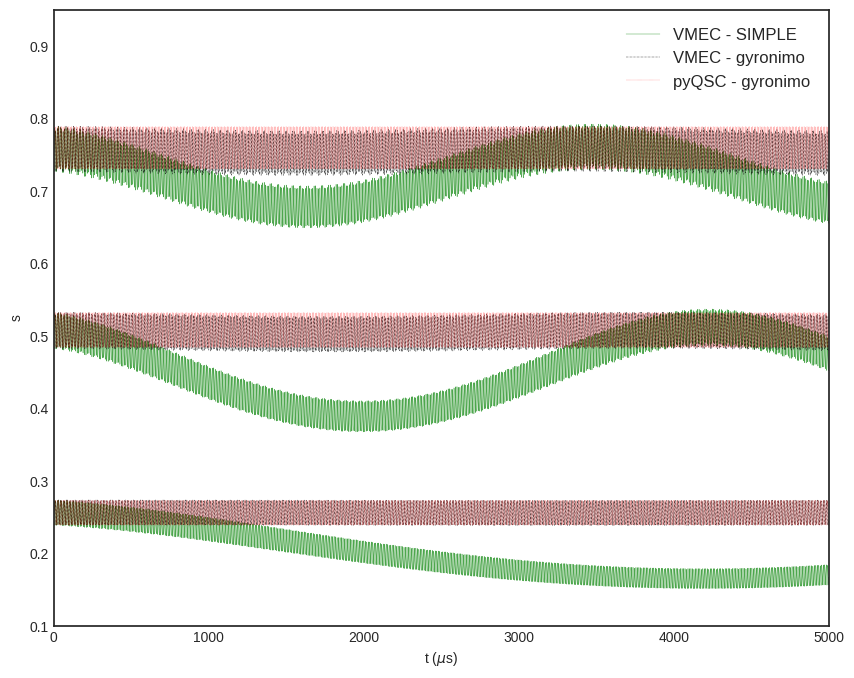

In [11]:
if not os.path.exists(stellarator + '_A=' + str(Rmajor_ARIES/r_avg)):
    os.mkdir(stellarator + '_A=' + str(Rmajor_ARIES/r_avg))
norms_r_pos=[]
norms_r_pos_filt=[]
for i in np.arange(0,int(len(g_orbits)/(len(s_initials))),1):  
    # f, (ax, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(12, 10))
    # f.subplots_adjust(hspace=0.05)  # adjust space between axes
    plt.figure(figsize=(10, 8))
    for j in np.arange(0, len(s_initials),1):
        for k in np.arange(0,1,2):
            s_i=i*len(s_initials)+j+k
            
            norm_r_pos = (g_orbits[s_i].r_pos/(r_avg))**2
            
            plt.rcParams["figure.facecolor"] = "w"
            plt.rcParams['lines.linewidth'] = 0.25
            # plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'black', 'r'])
            plt.style.use('seaborn-v0_8-white')
            if j+k==0:
                plt.plot(g_orbits_simple[s_i].time*1e6, g_orbits_simple[s_i].r_pos, ls='solid', c='g',label='VMEC - SIMPLE')
                plt.plot(g_orbits_vmec[s_i].time*1e6, g_orbits_vmec[s_i].r_pos, ls='dashdot', c='black',label='VMEC - gyronimo')
                plt.plot(g_orbits[s_i].time*1e6, norm_r_pos, ls='dotted', c='r',label='pyQSC - gyronimo')
            elif j+k==1:
                plt.plot(g_orbits_simple[s_i].time*1e6, g_orbits_simple[s_i].r_pos, ls='solid', c='g')
                plt.plot(g_orbits_vmec[s_i].time*1e6, g_orbits_vmec[s_i].r_pos, ls='dashdot', c='black')
                plt.plot(g_orbits[s_i].time*1e6, norm_r_pos, ls='dotted', c='r')
            else:
                plt.plot(g_orbits_simple[s_i].time*1e6, g_orbits_simple[s_i].r_pos, ls='solid',c='g')
                plt.plot(g_orbits_vmec[s_i].time*1e6, g_orbits_vmec[s_i].r_pos, ls='dashdot',c='black')
                plt.plot(g_orbits[s_i].time*1e6, norm_r_pos, ls='dotted', c='r')
    if not os.path.exists(stellarator + '_A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(i)):
        os.mkdir(stellarator + '_A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(i))
    # ax.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
    plt.xlabel(r't ($\mu$s)')
    plt.ylabel(r's')
    # ax2.set_ylabel(r's')#$\psi$/$\psi_0$')
    # ax2.set_ylim(0.45,0.6)
    # ax.set_ylim(0.7,0.85)
    # ax3.set_ylim(0.2,0.35)
    # ax3.spines.top.set_visible(False)
    # ax2.spines.bottom.set_visible(False)
    # ax2.spines.top.set_visible(False)
    # ax.spines.bottom.set_visible(False)
    # ax3.locator_params(axis='y', nbins=5)
    # ax2.locator_params(axis='y', nbins=5)
    # ax.locator_params(axis='y', nbins=5)
    # ax2.yticks(3)
    # ax.yticks(3)

    # d = .5  # proportion of vertical to horizontal extent of the slanted line
    # kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
    #             linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    # ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)
    # ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
    # ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    # ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)

    t=5000
    plt.xlim(0*t,1*t)
    plt.ylim(0.1,0.95)
    # plt.legend(loc=(0.78,2.75),fontsize=12)
    plt.legend(loc=(0.73,0.86),fontsize=12)
    plt.savefig(stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(i)+'/r_pos'+str(t)+'micro_all.pdf',transparent=False)
    # plt.savefig('best_try_' + str(s_i) + '.pdf')
    plt.show()


<Figure size 1000x600 with 0 Axes>

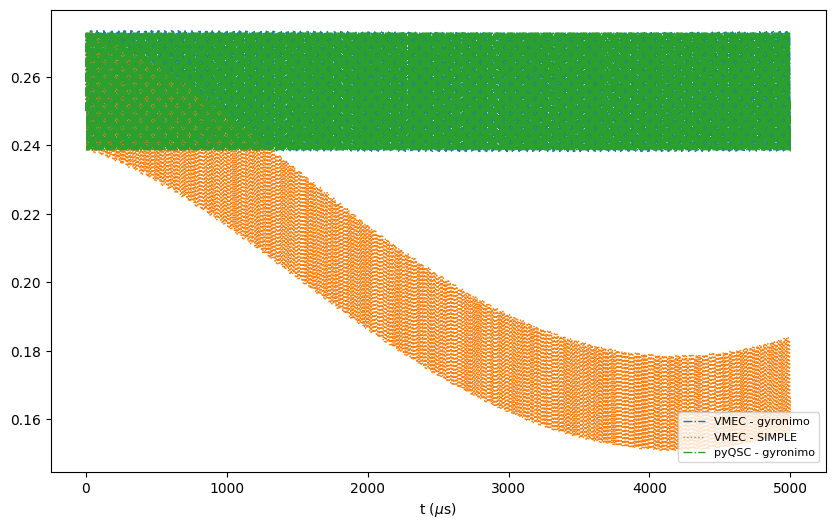

NEAT


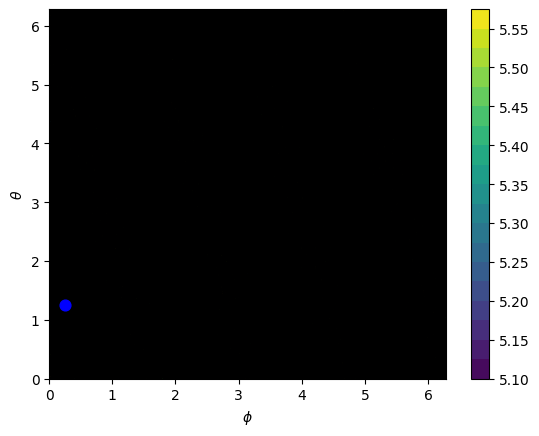

VMEC


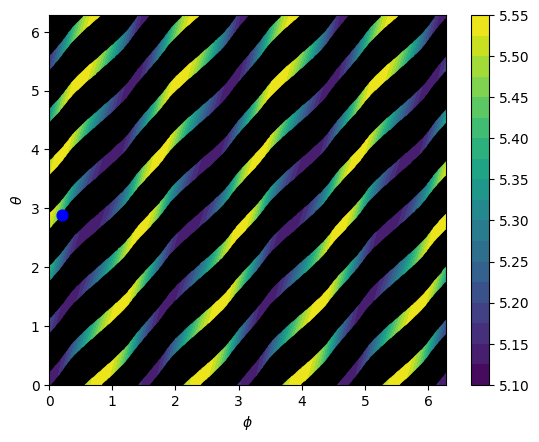

SIMPLE


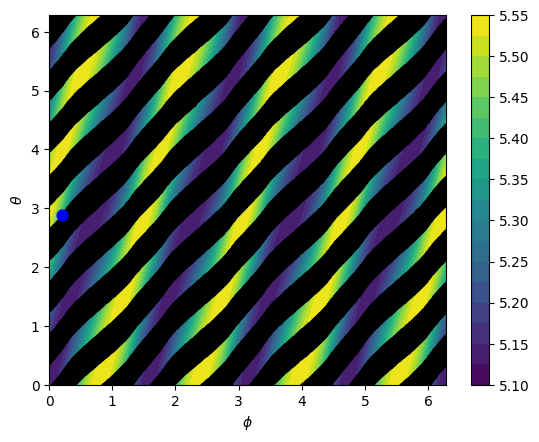

NEAT-VMEC


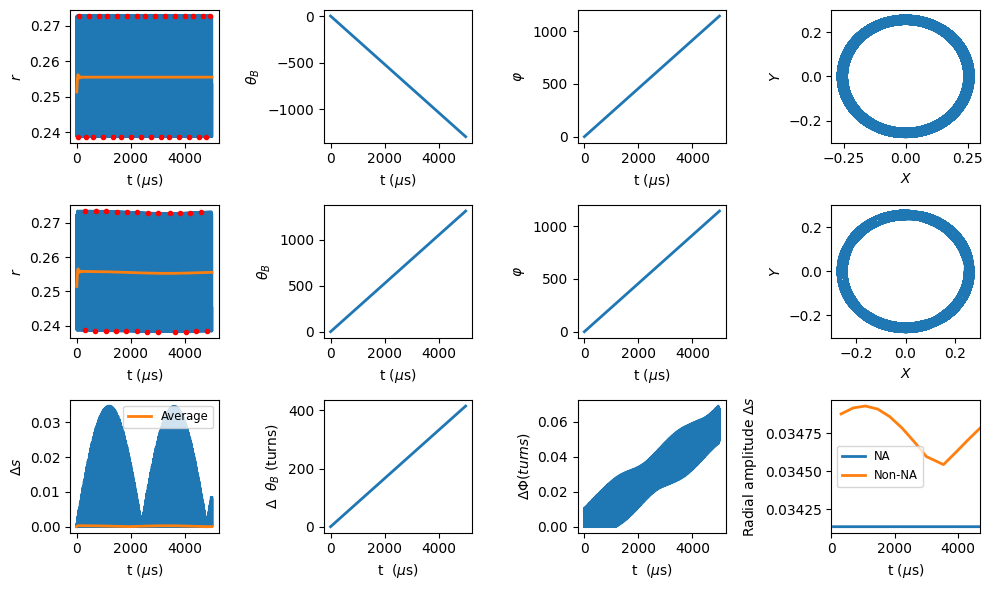

NEAT-SIMPLE


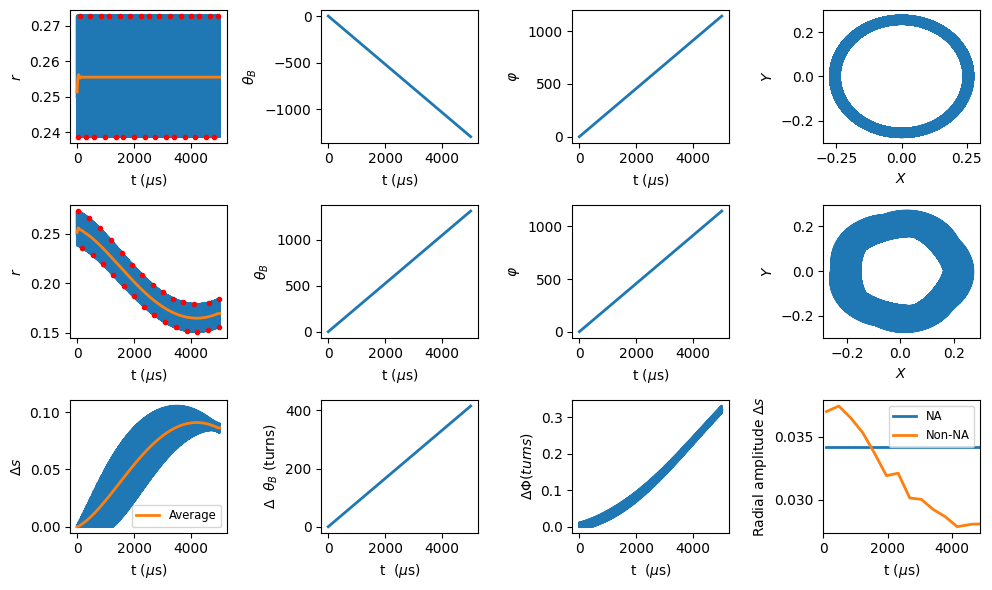

VMEC-SIMPLE


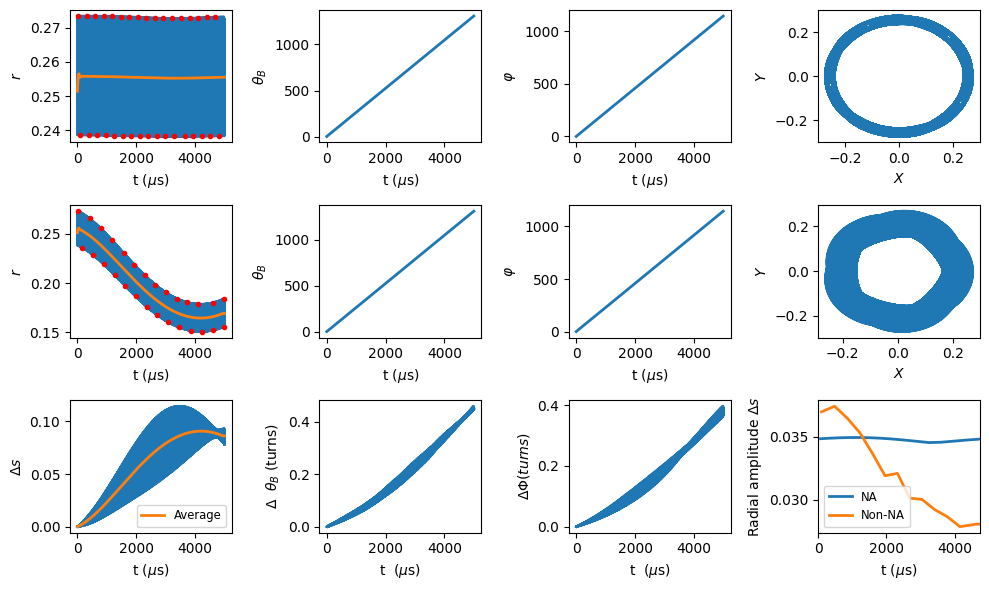

NEAT-VMEC


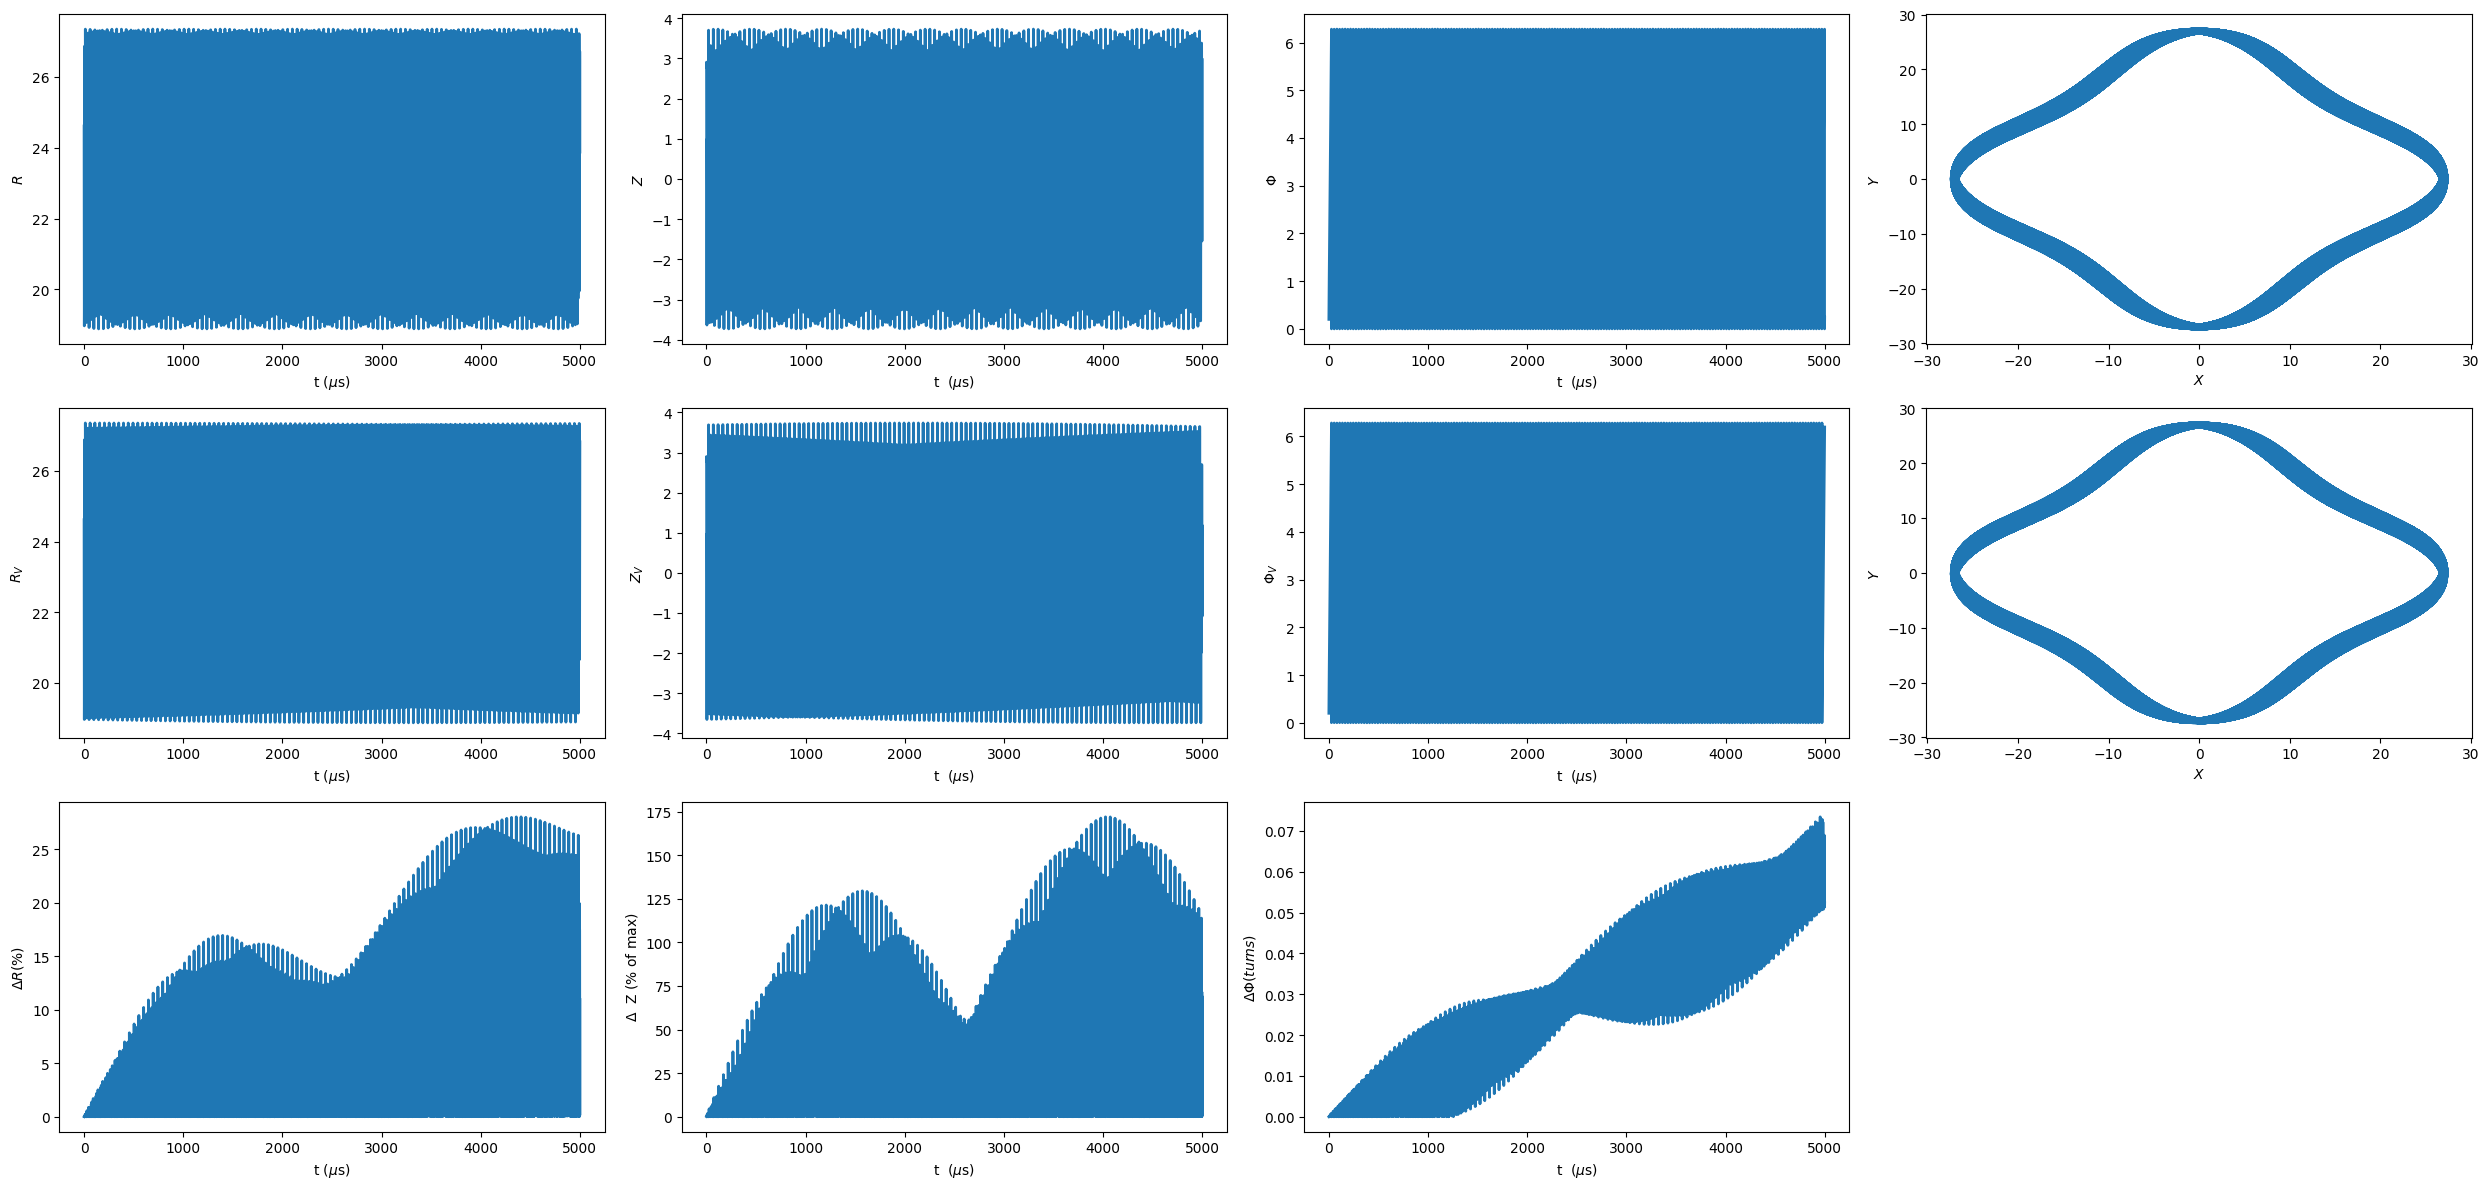

NEAT-SIMPLE


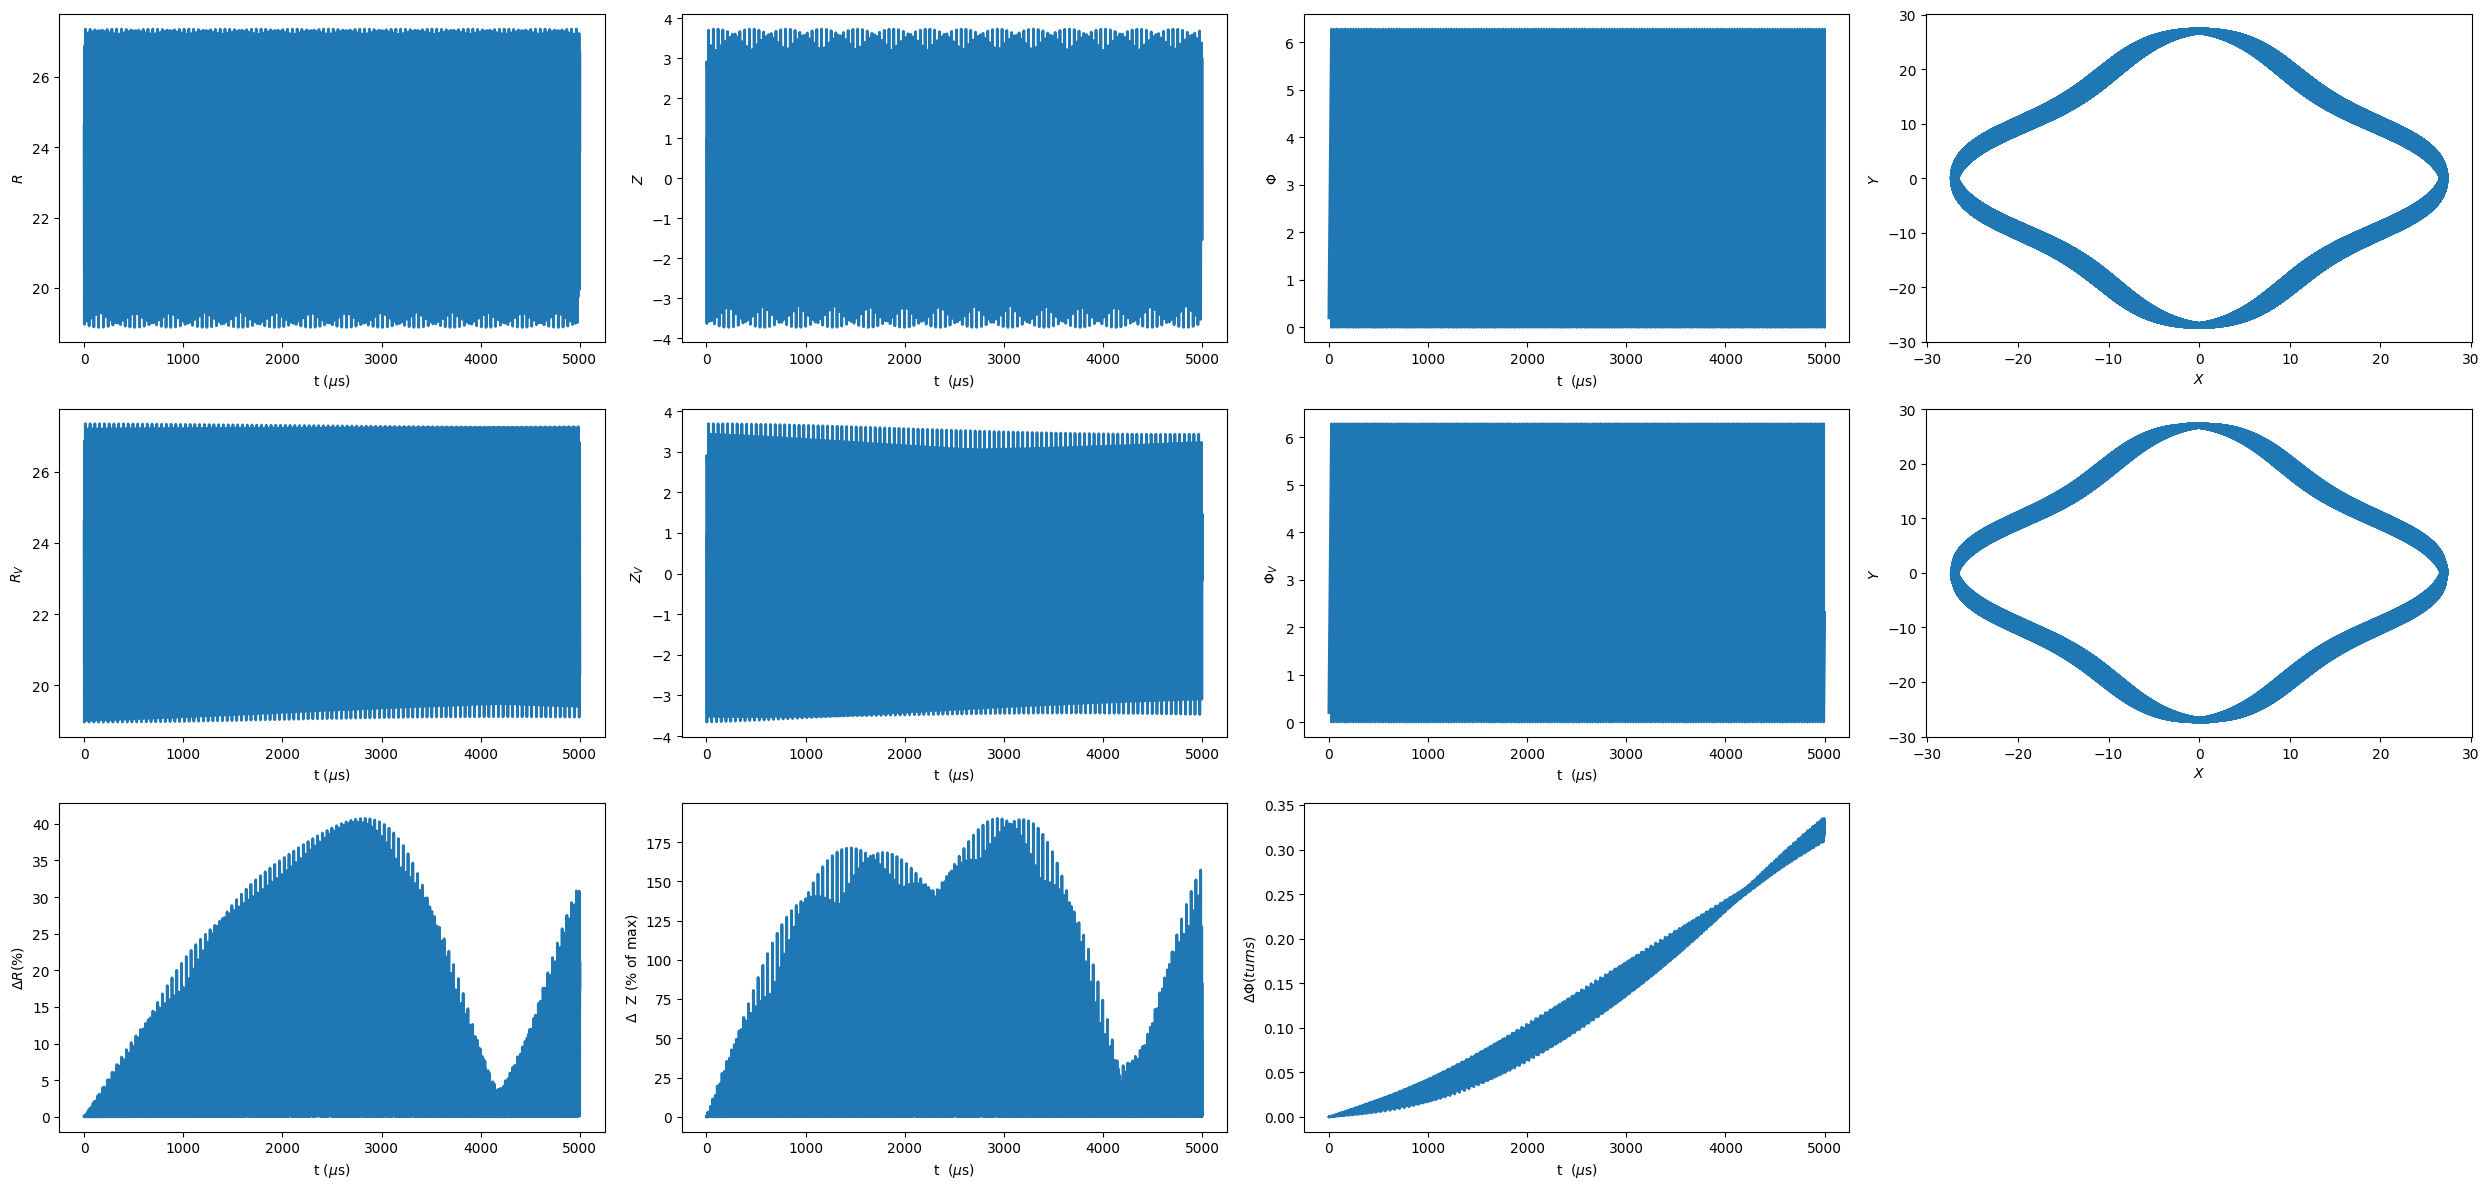

VMEC-SIMPLE


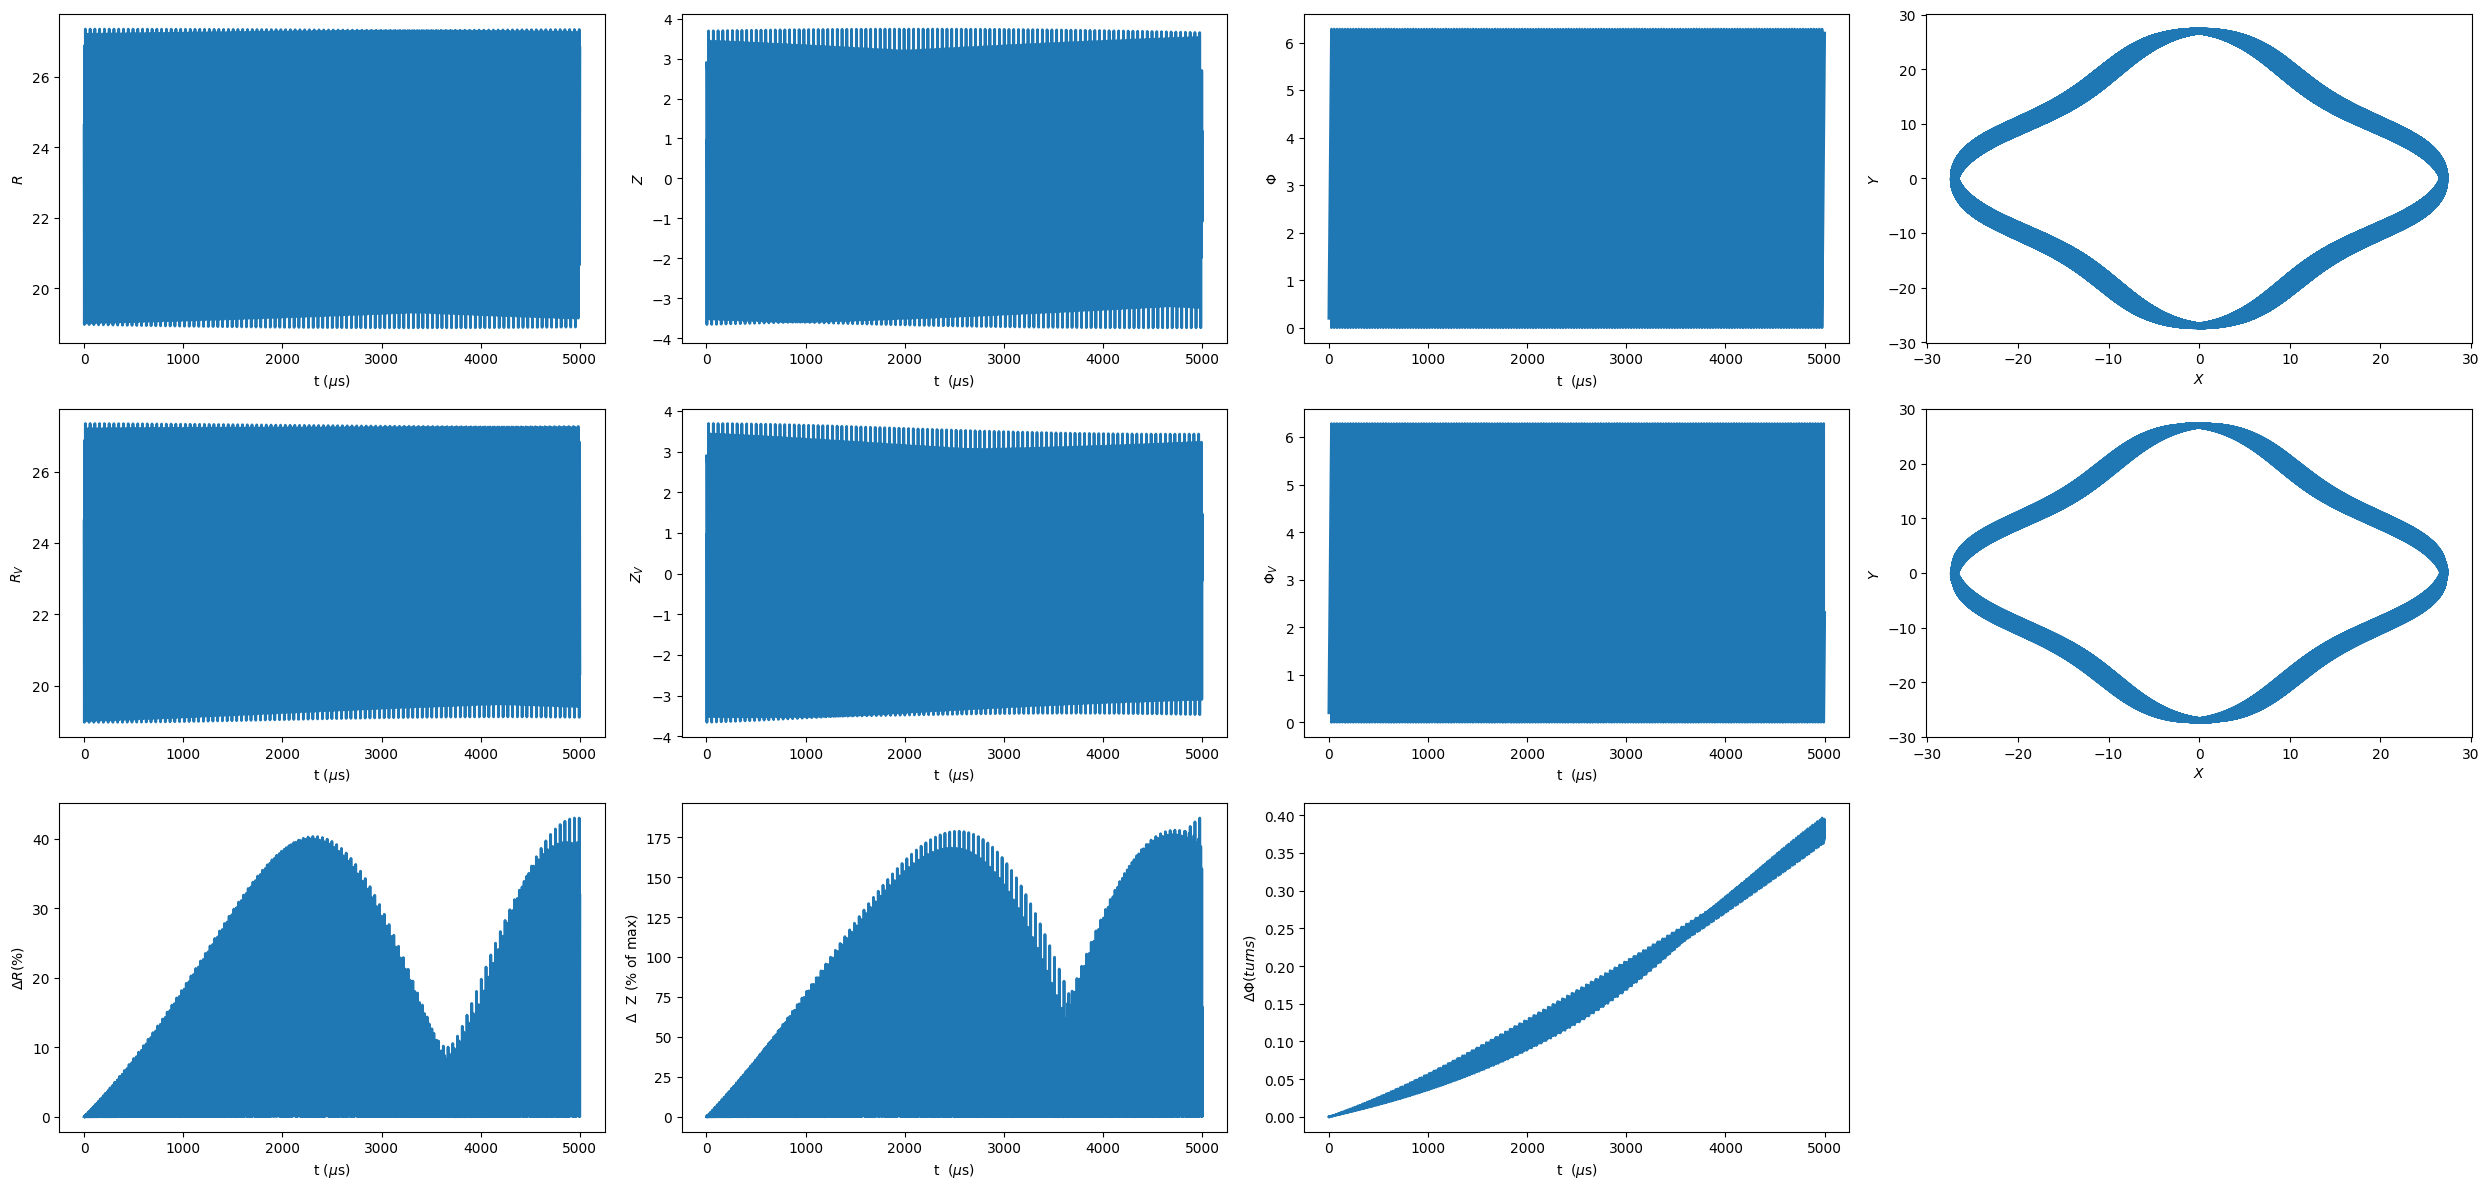

NEAT


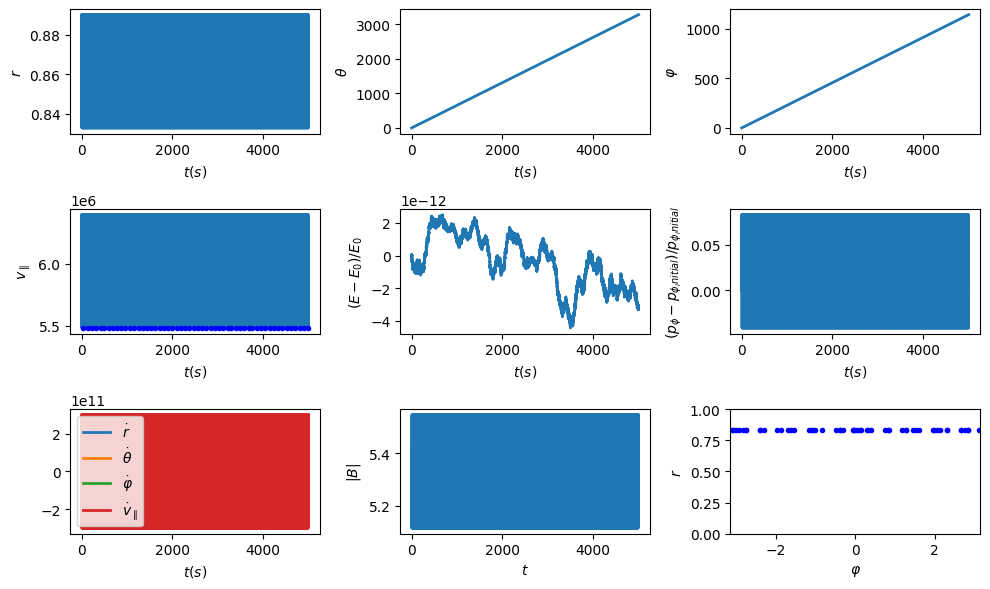

VMEC


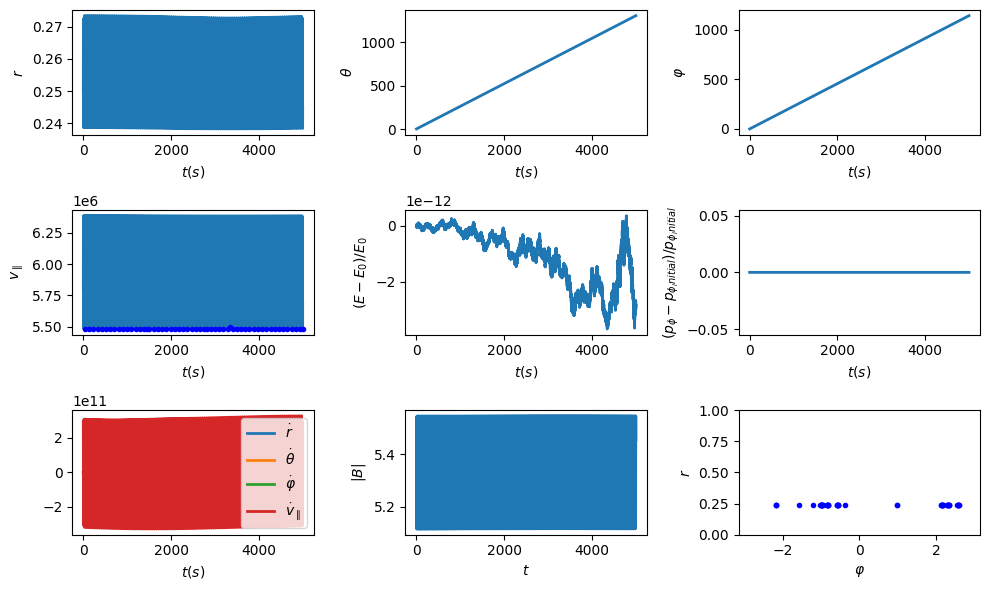

SIMPLE


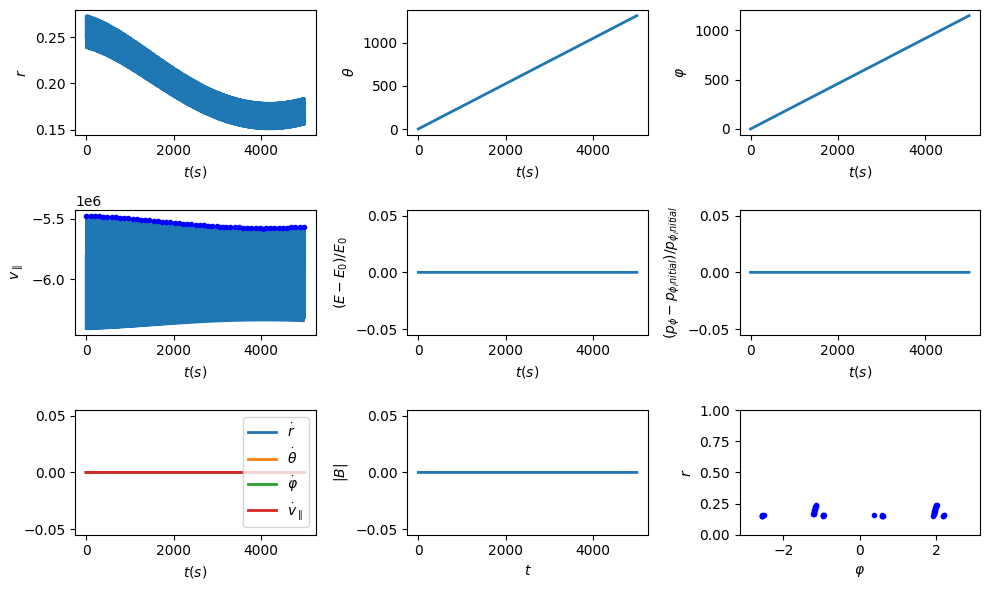

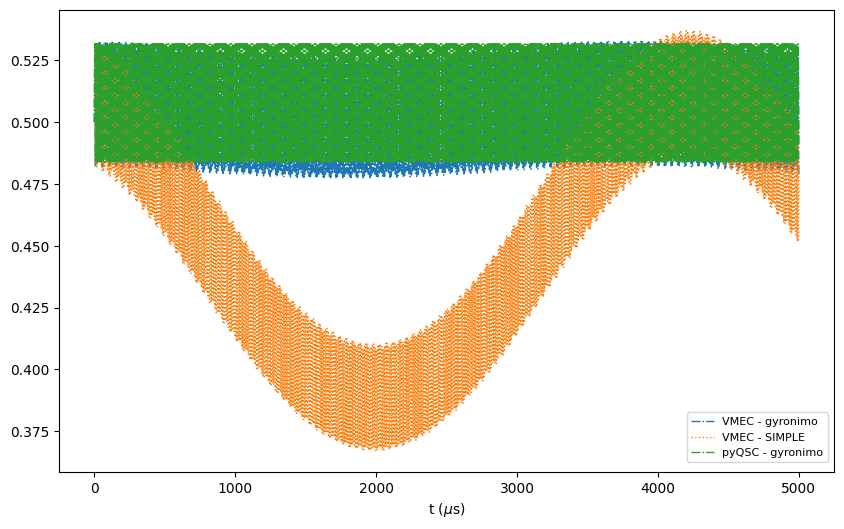

NEAT


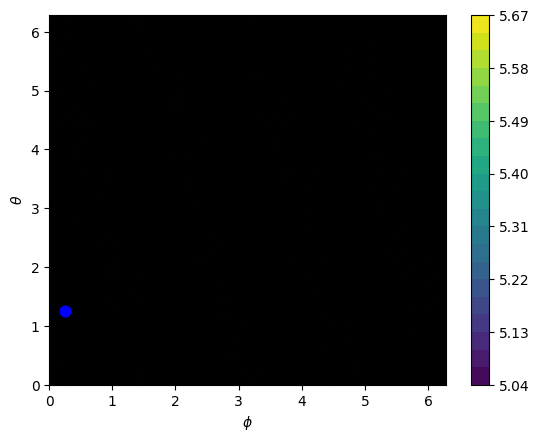

VMEC


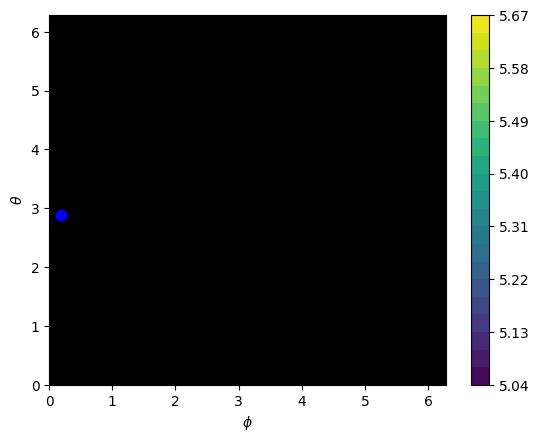

SIMPLE


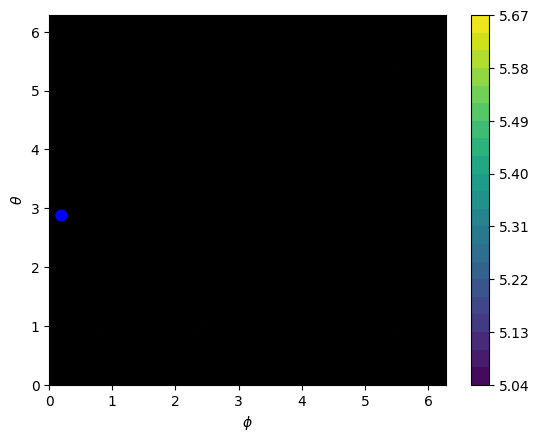

NEAT-VMEC


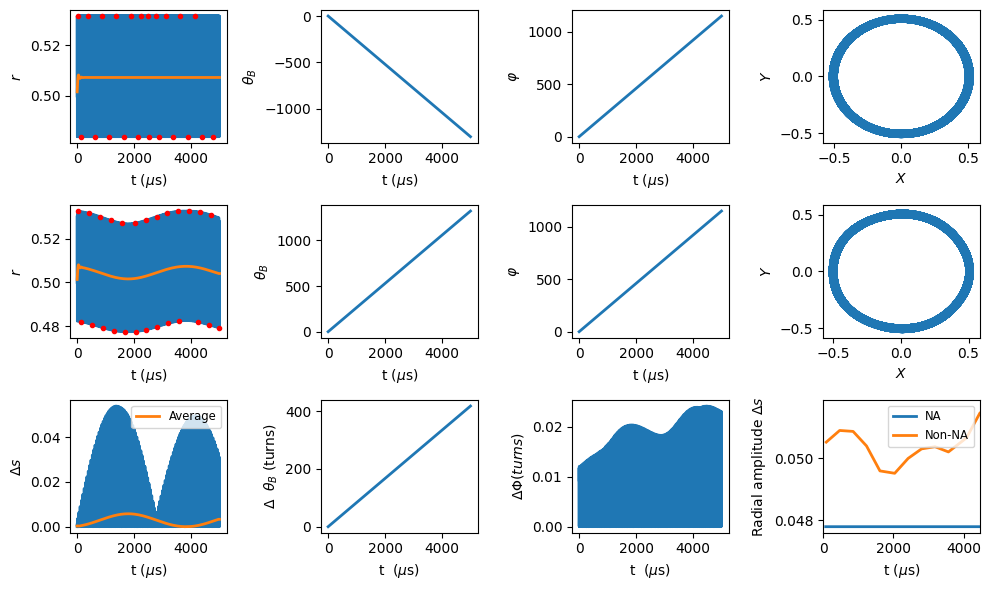

NEAT-SIMPLE


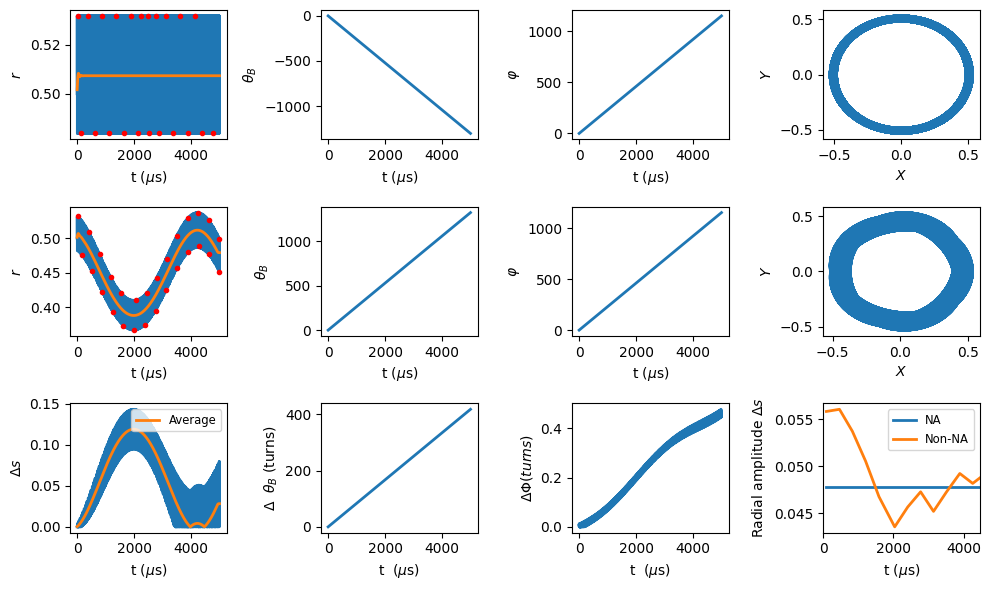

VMEC-SIMPLE


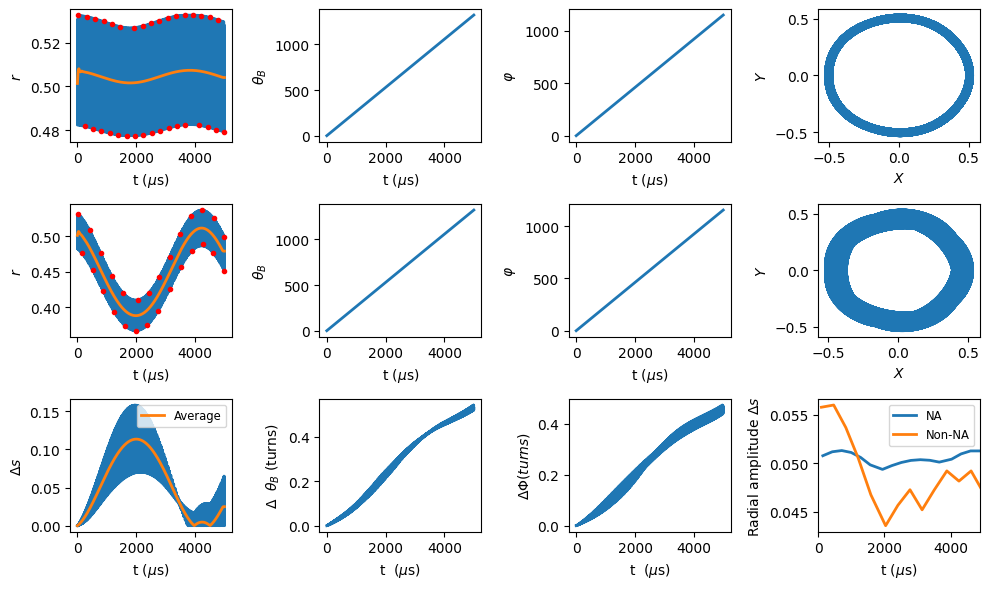

NEAT-VMEC


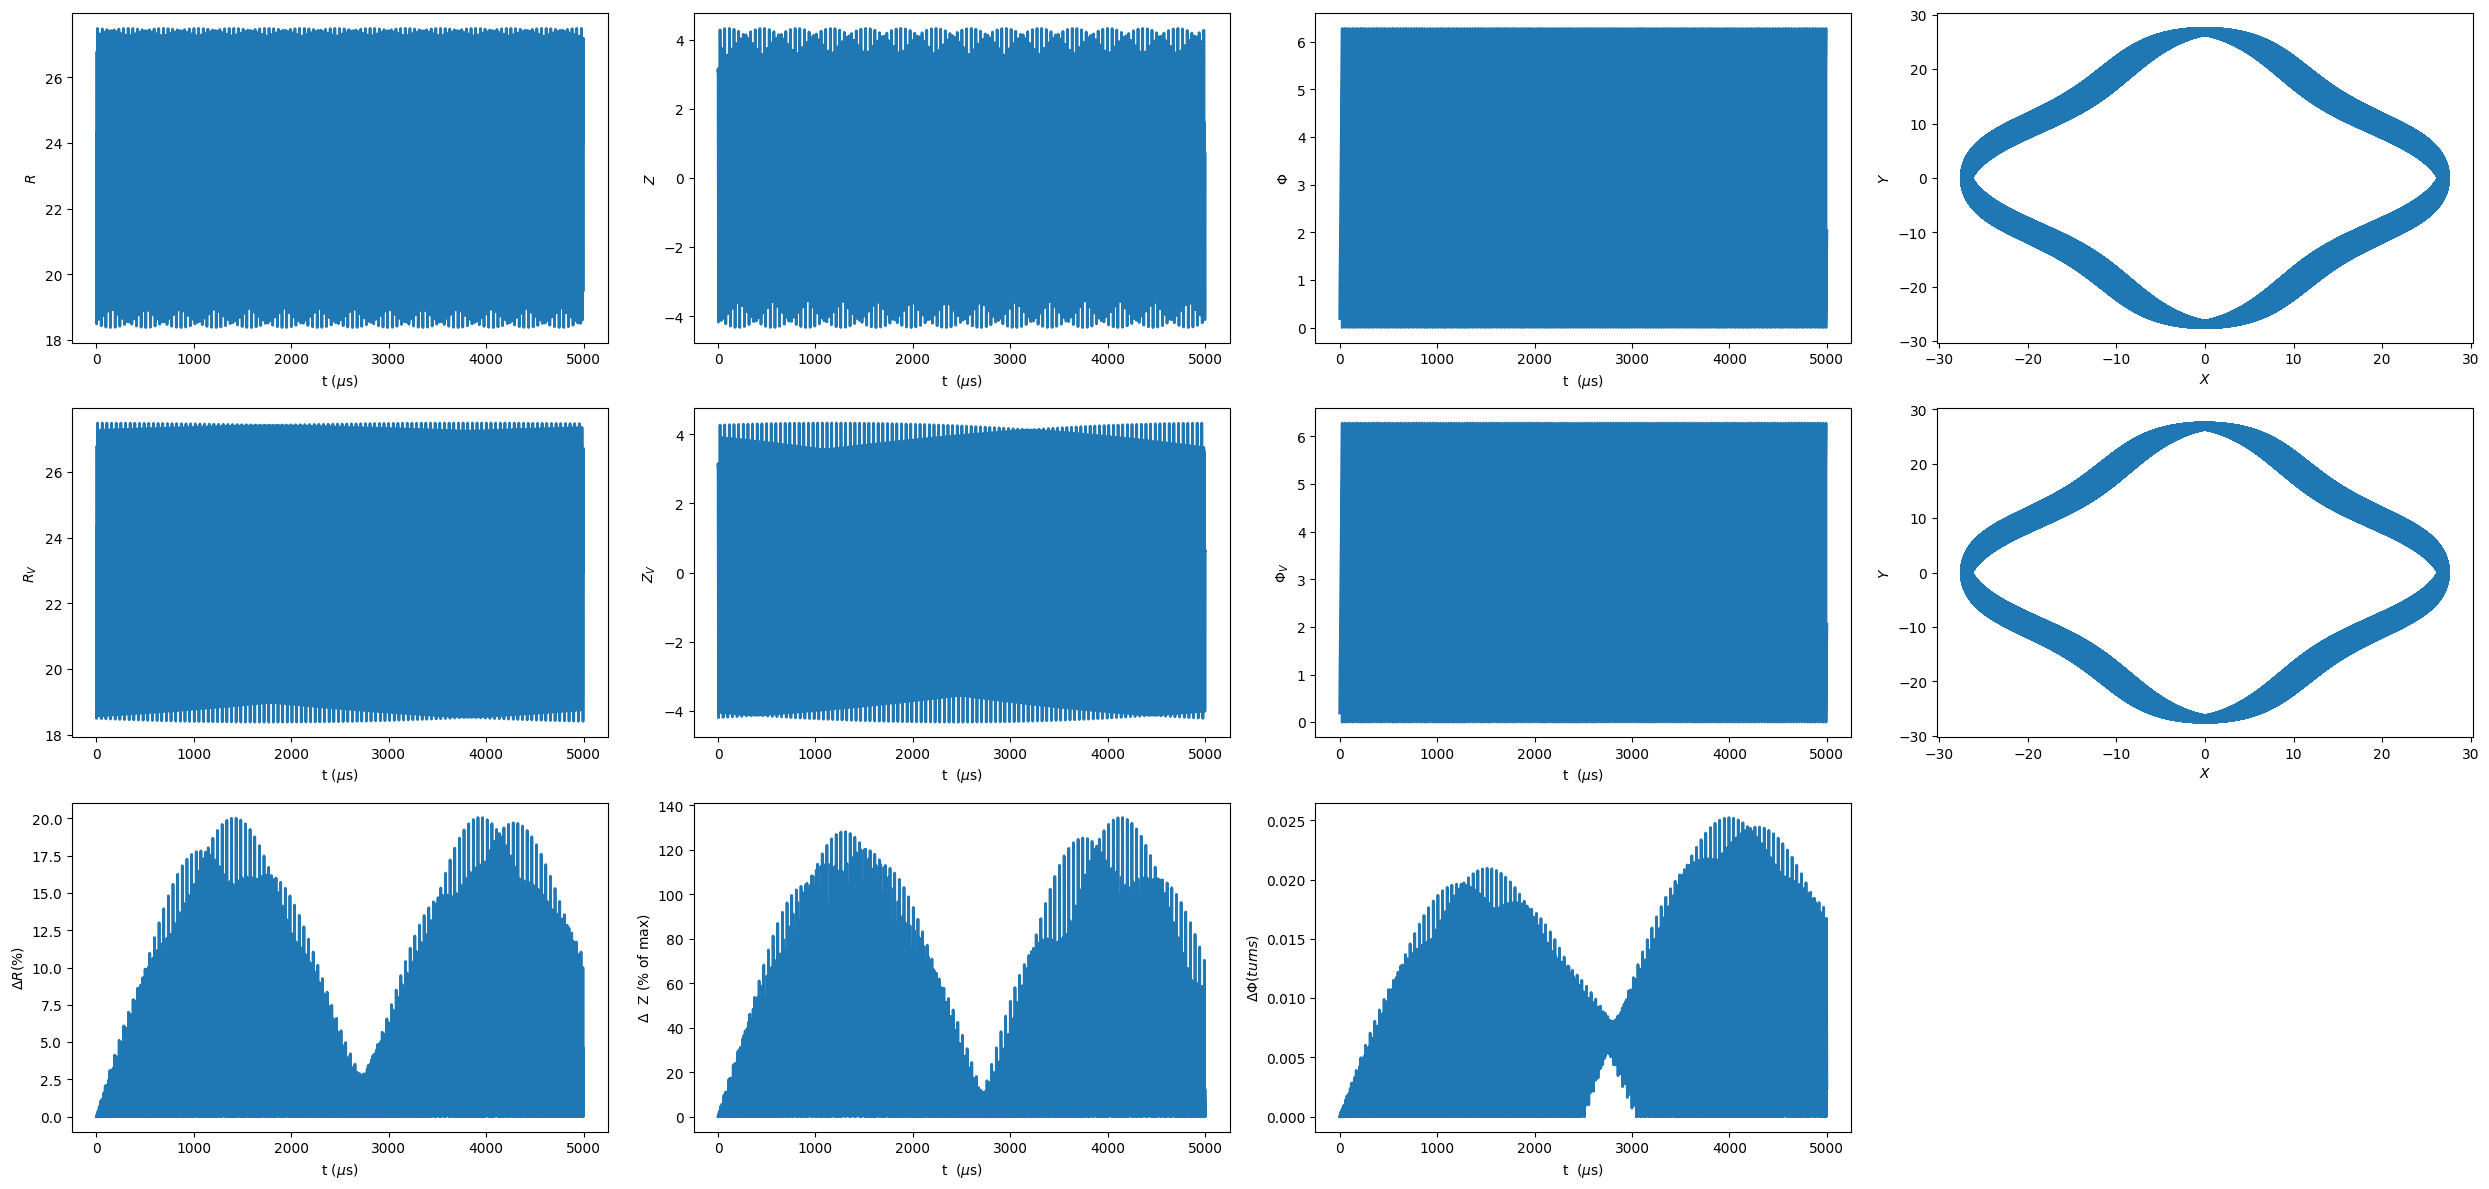

NEAT-SIMPLE


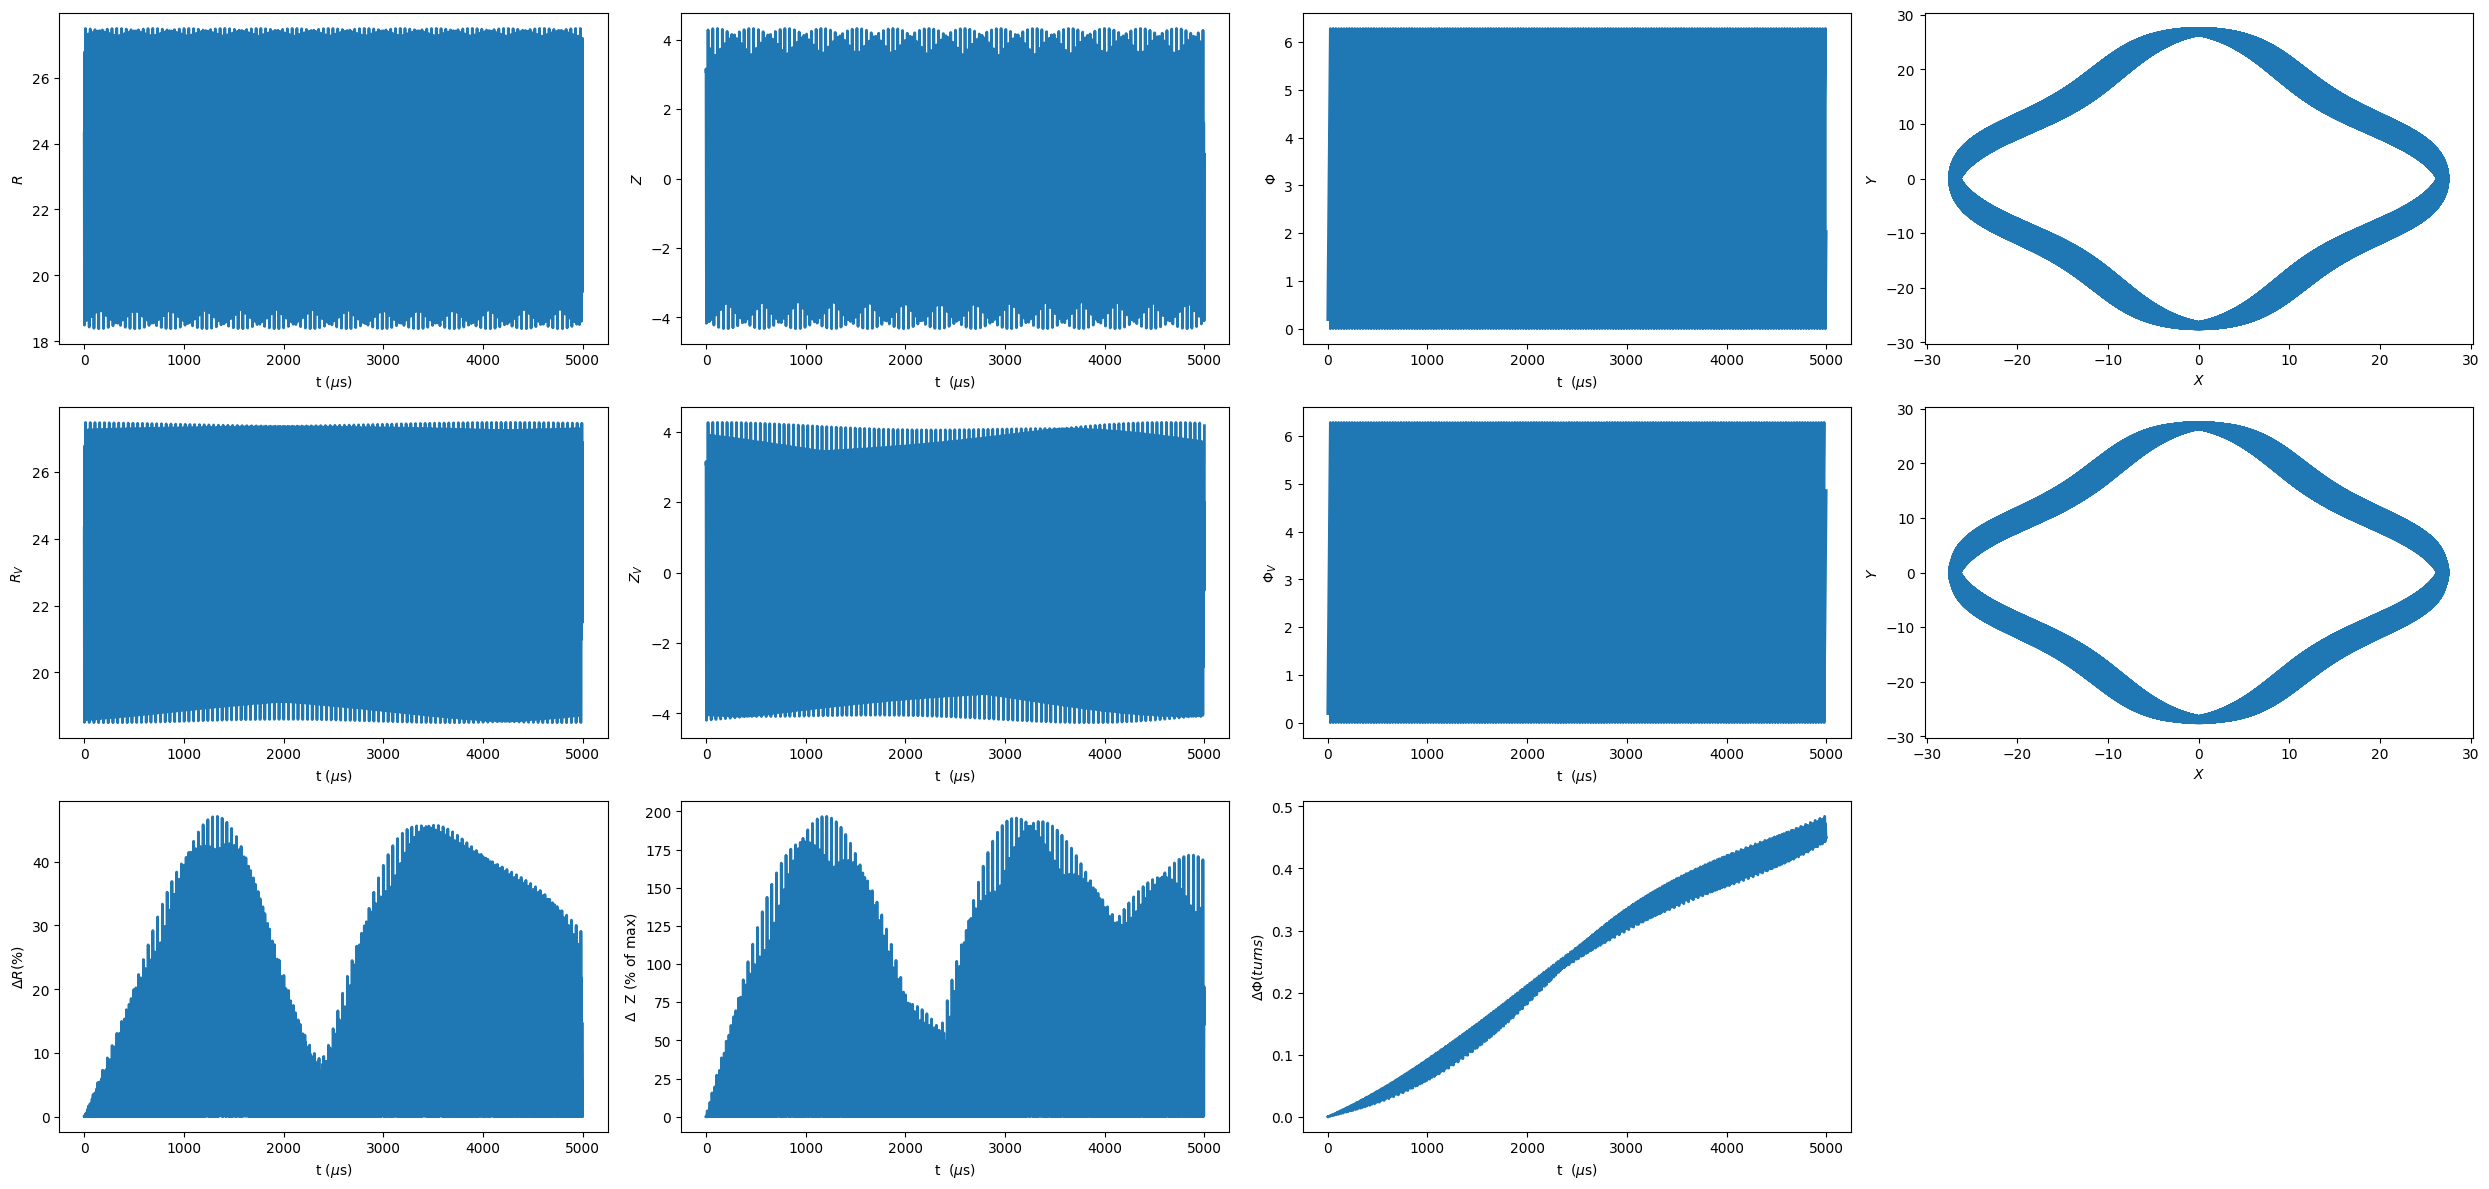

VMEC-SIMPLE


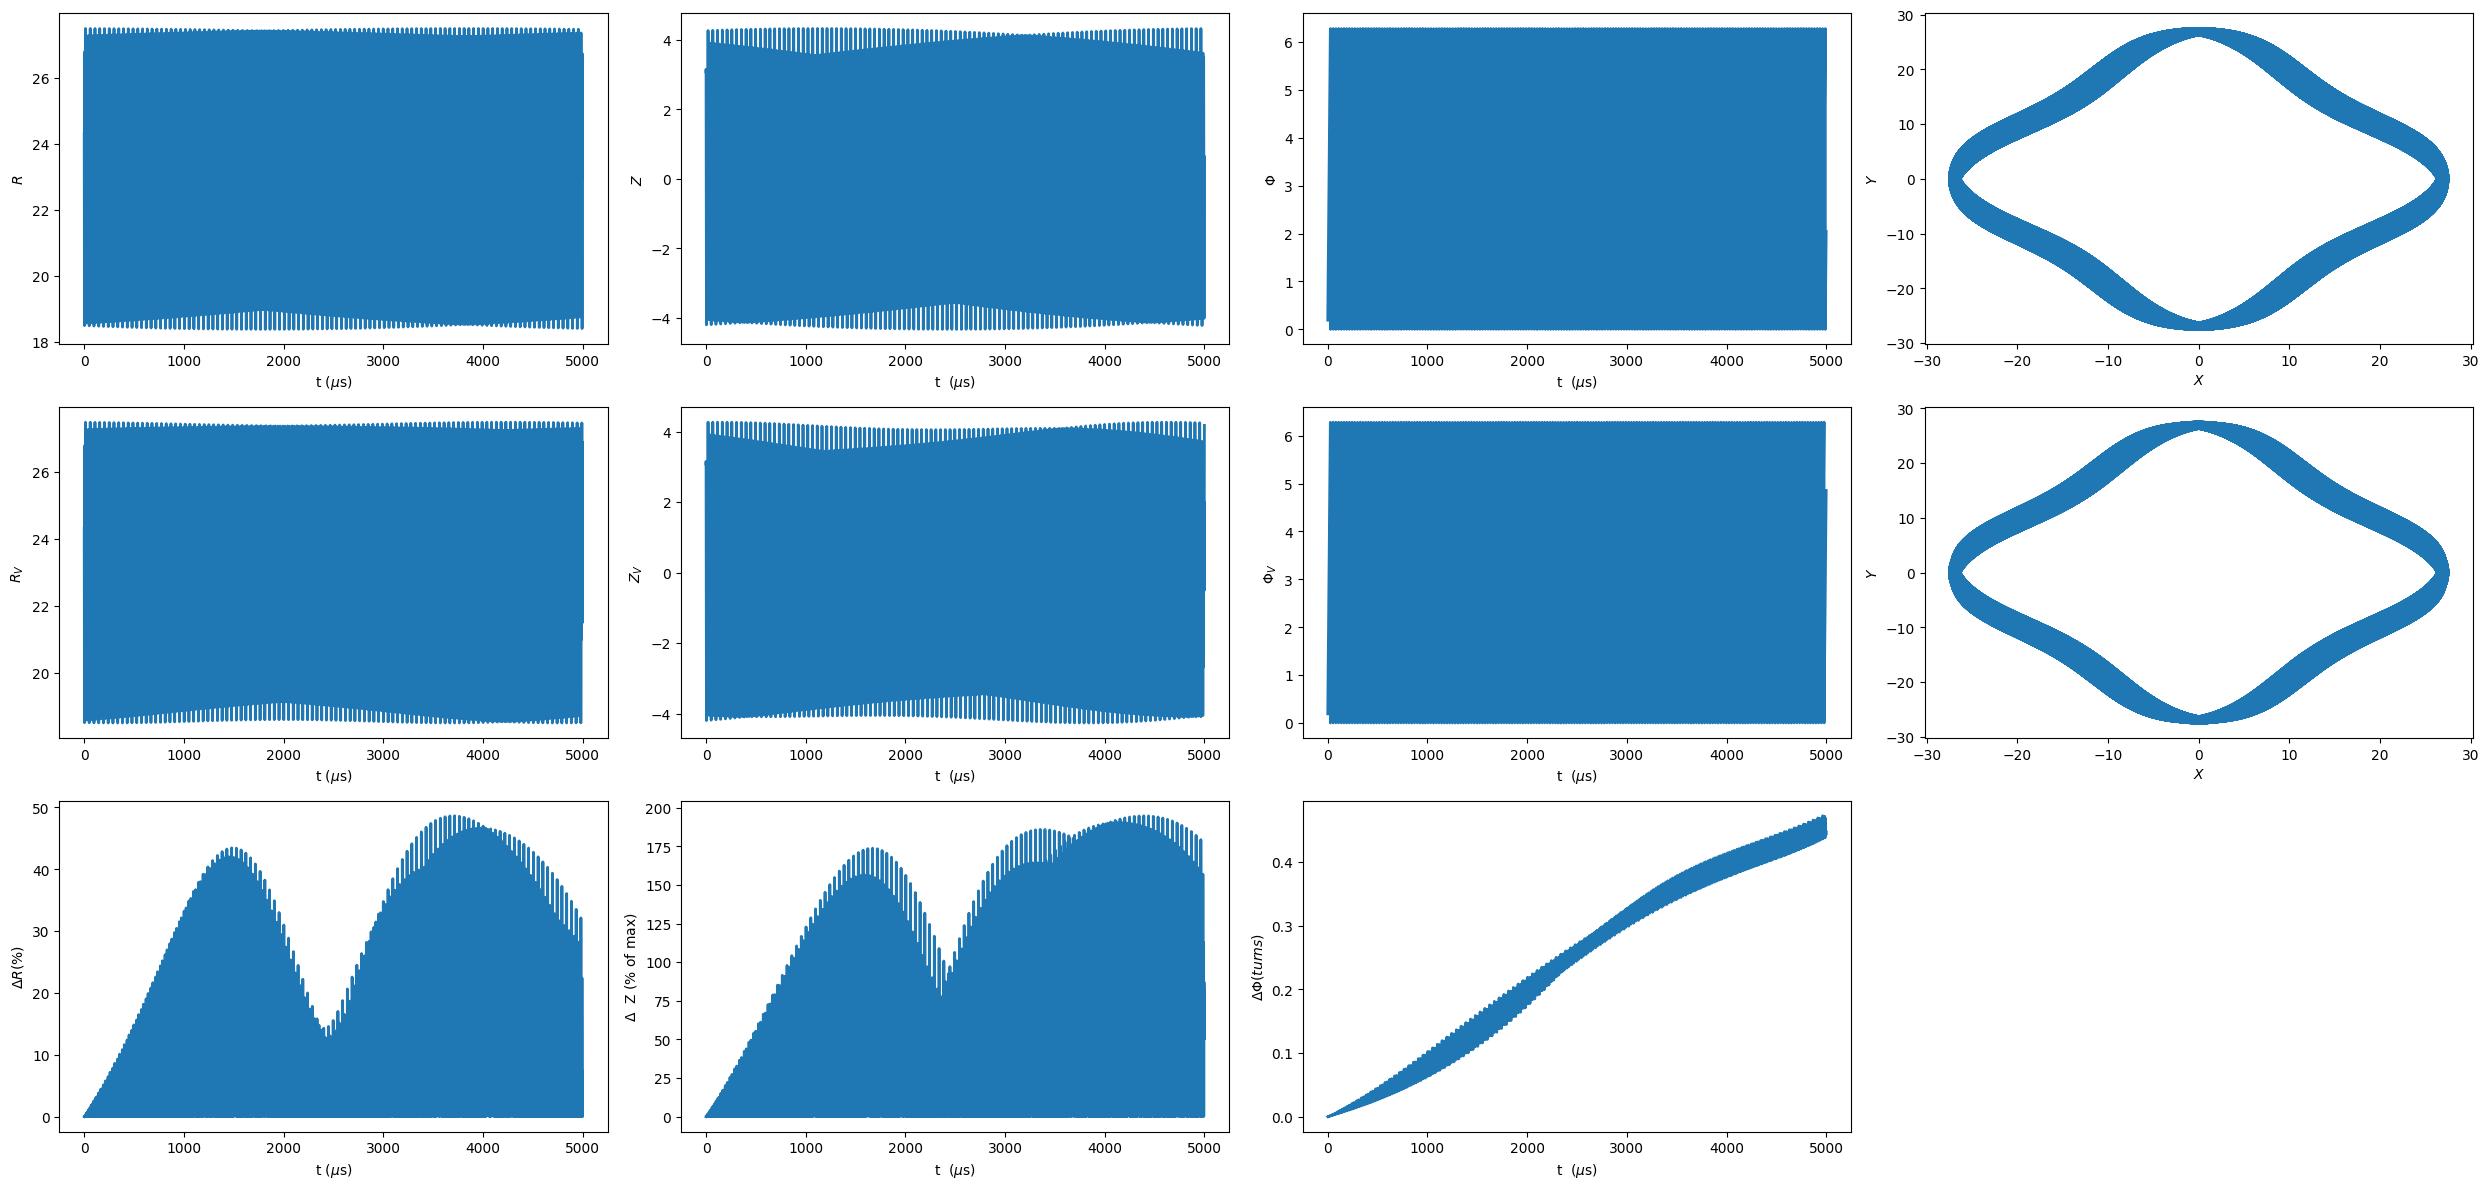

NEAT


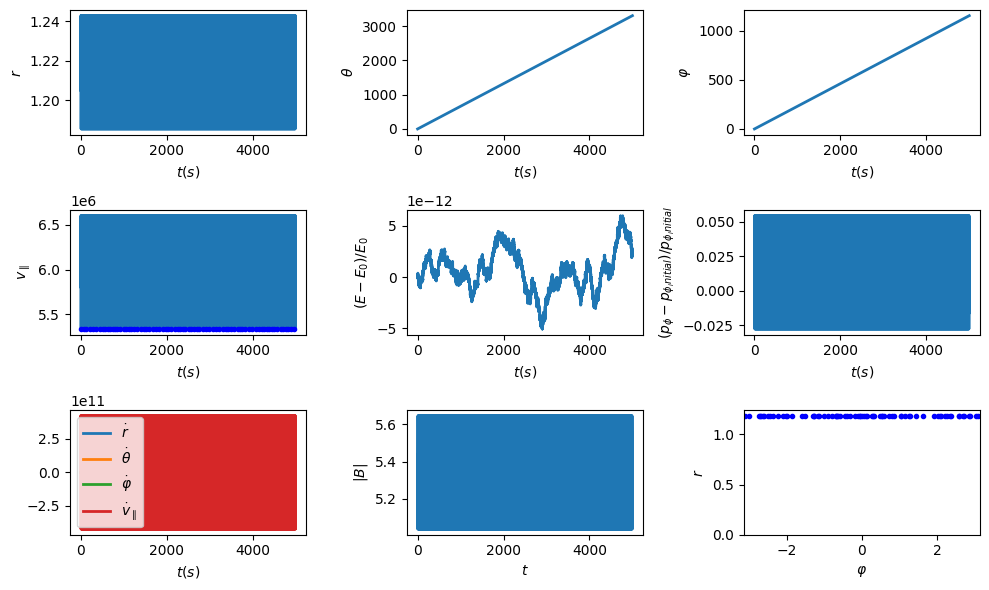

VMEC


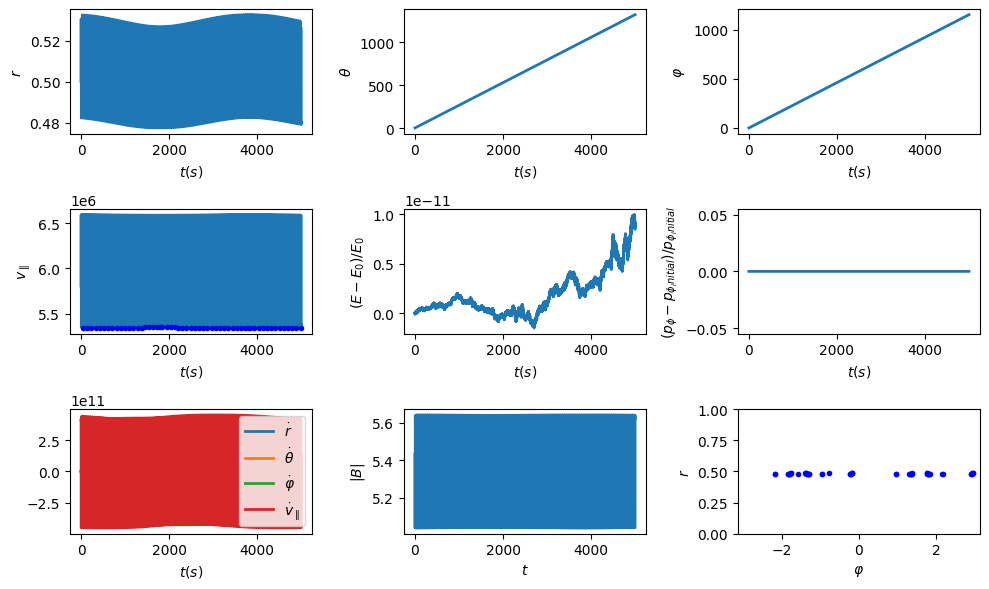

SIMPLE


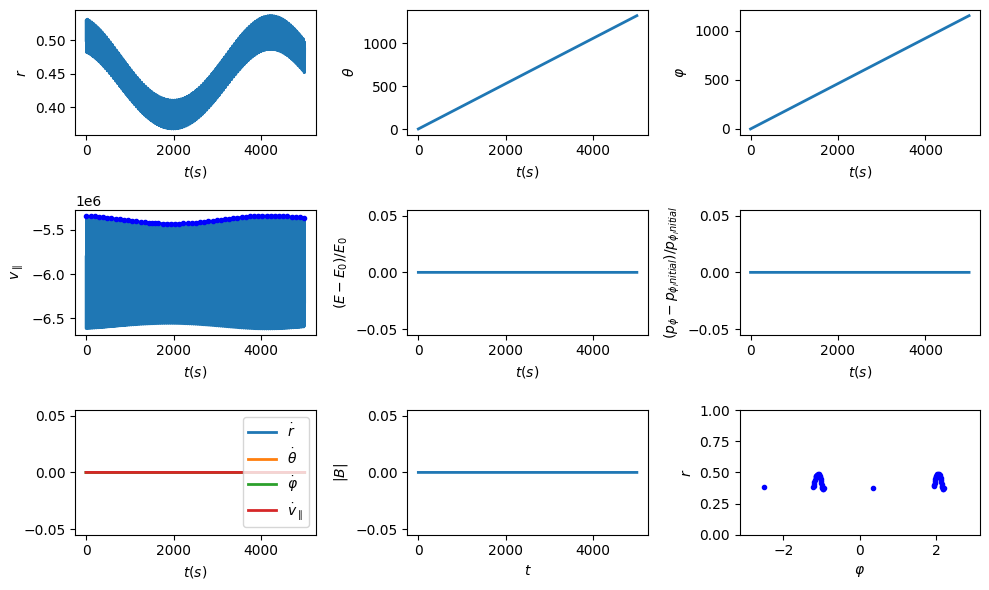

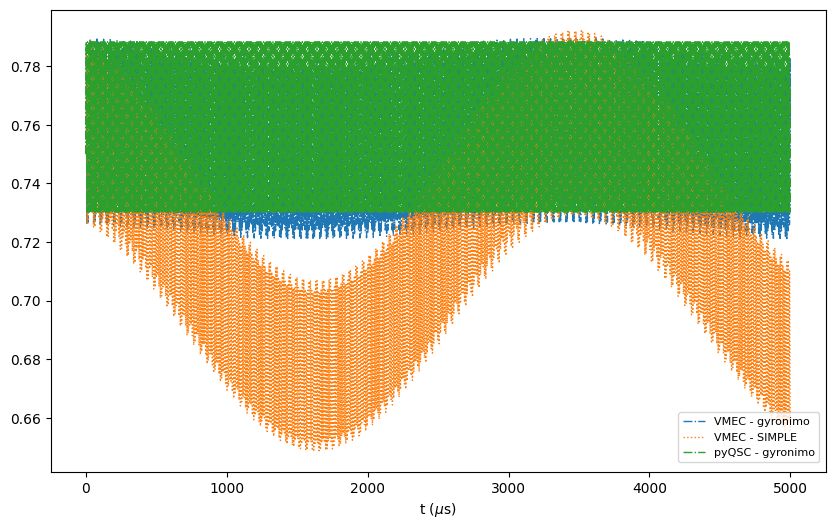

NEAT


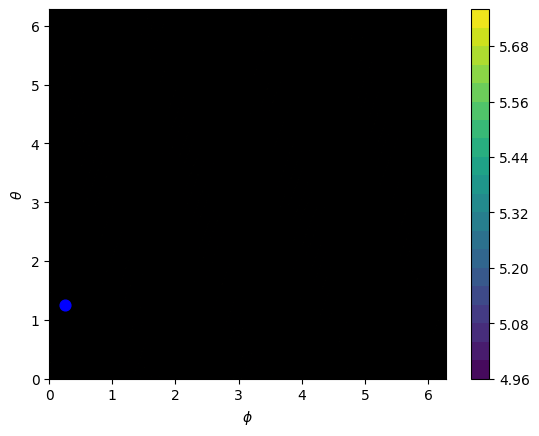

VMEC


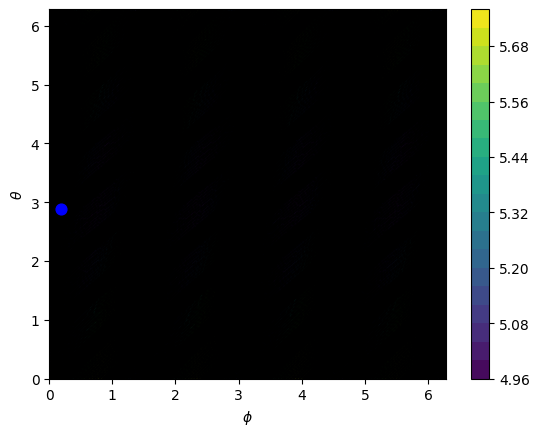

SIMPLE


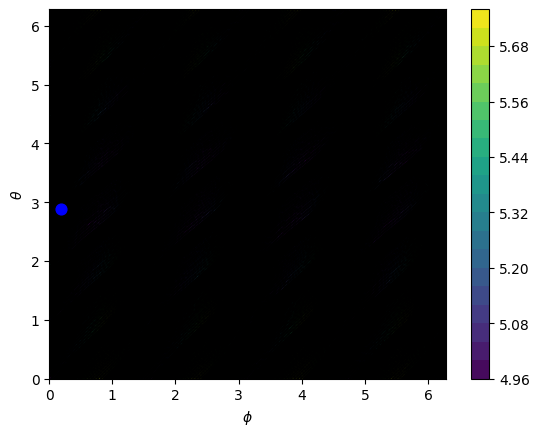

NEAT-VMEC


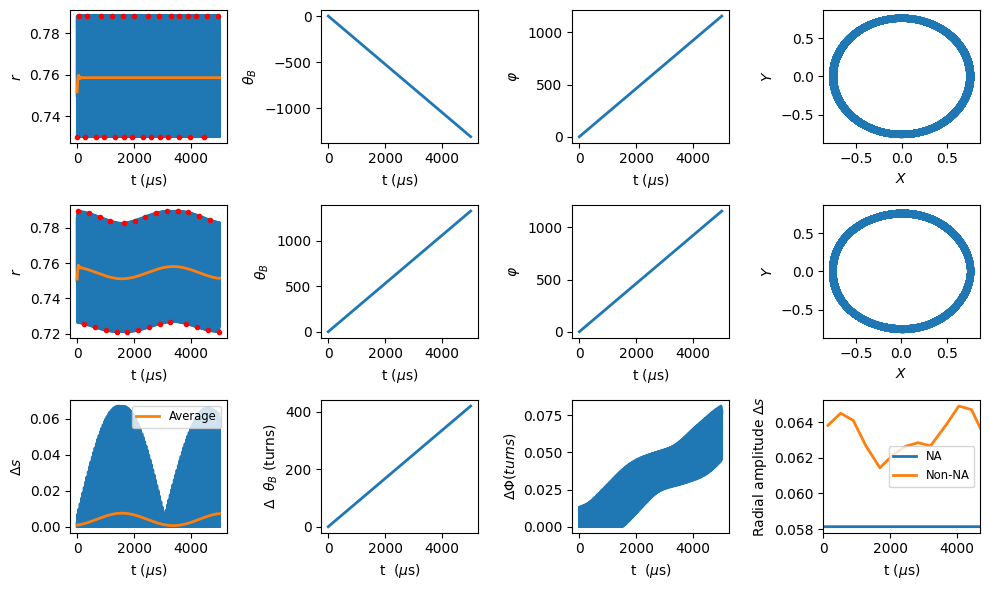

NEAT-SIMPLE


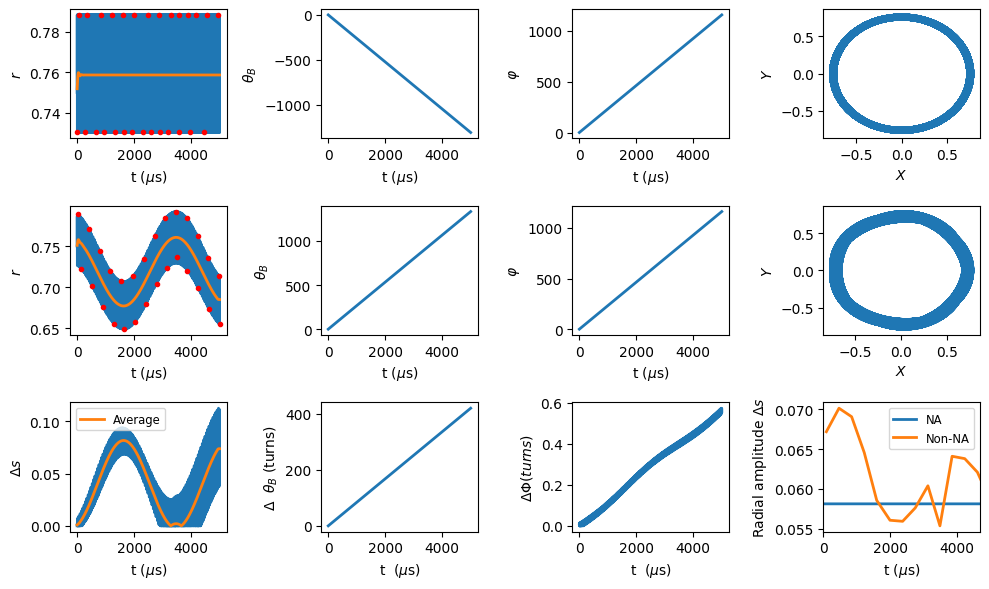

VMEC-SIMPLE


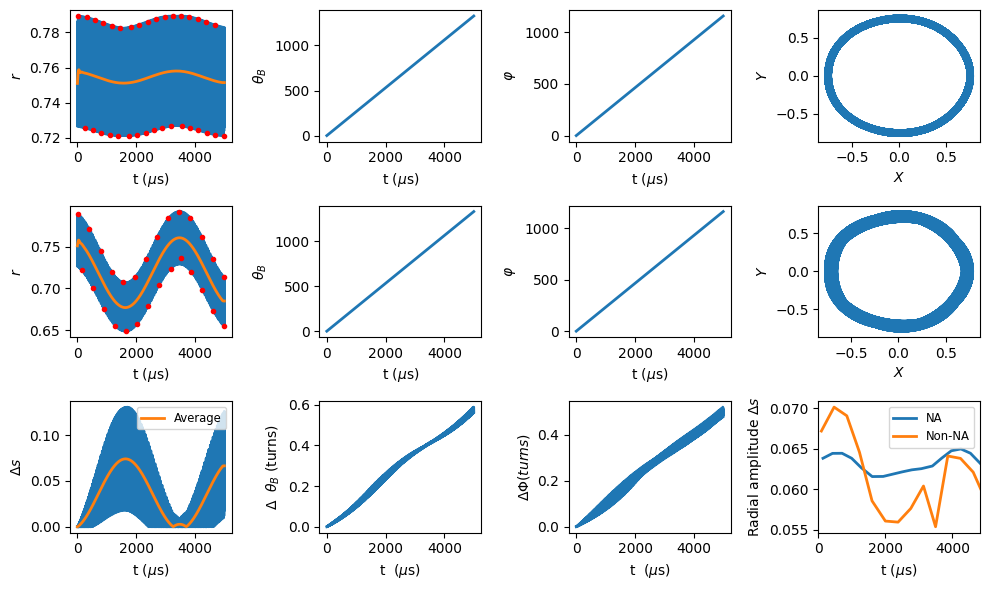

NEAT-VMEC


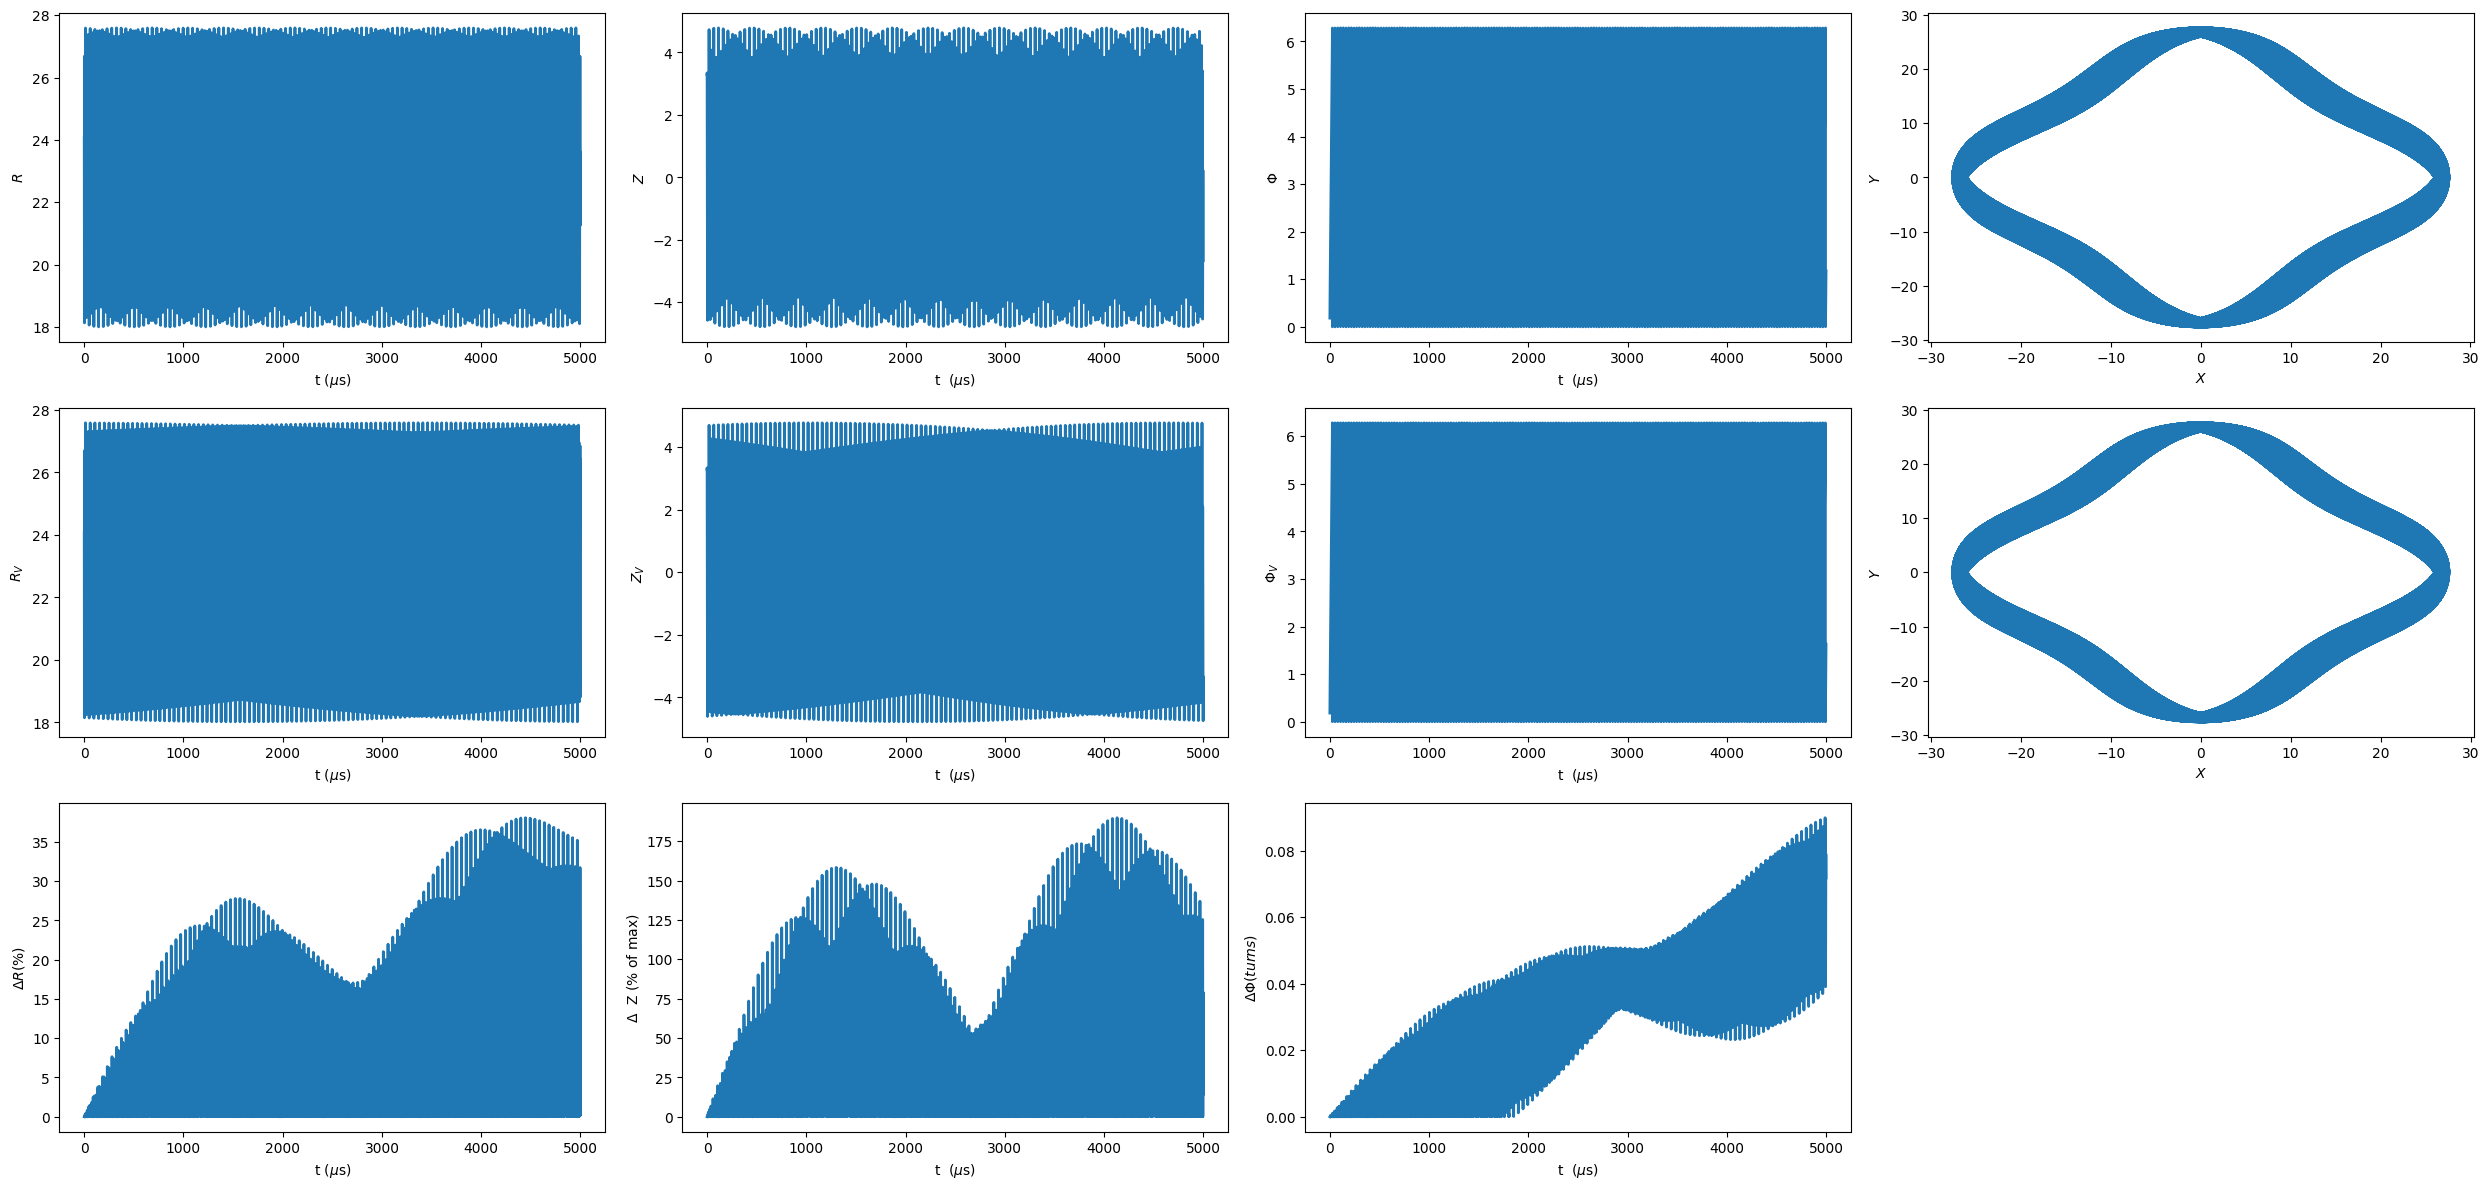

NEAT-SIMPLE


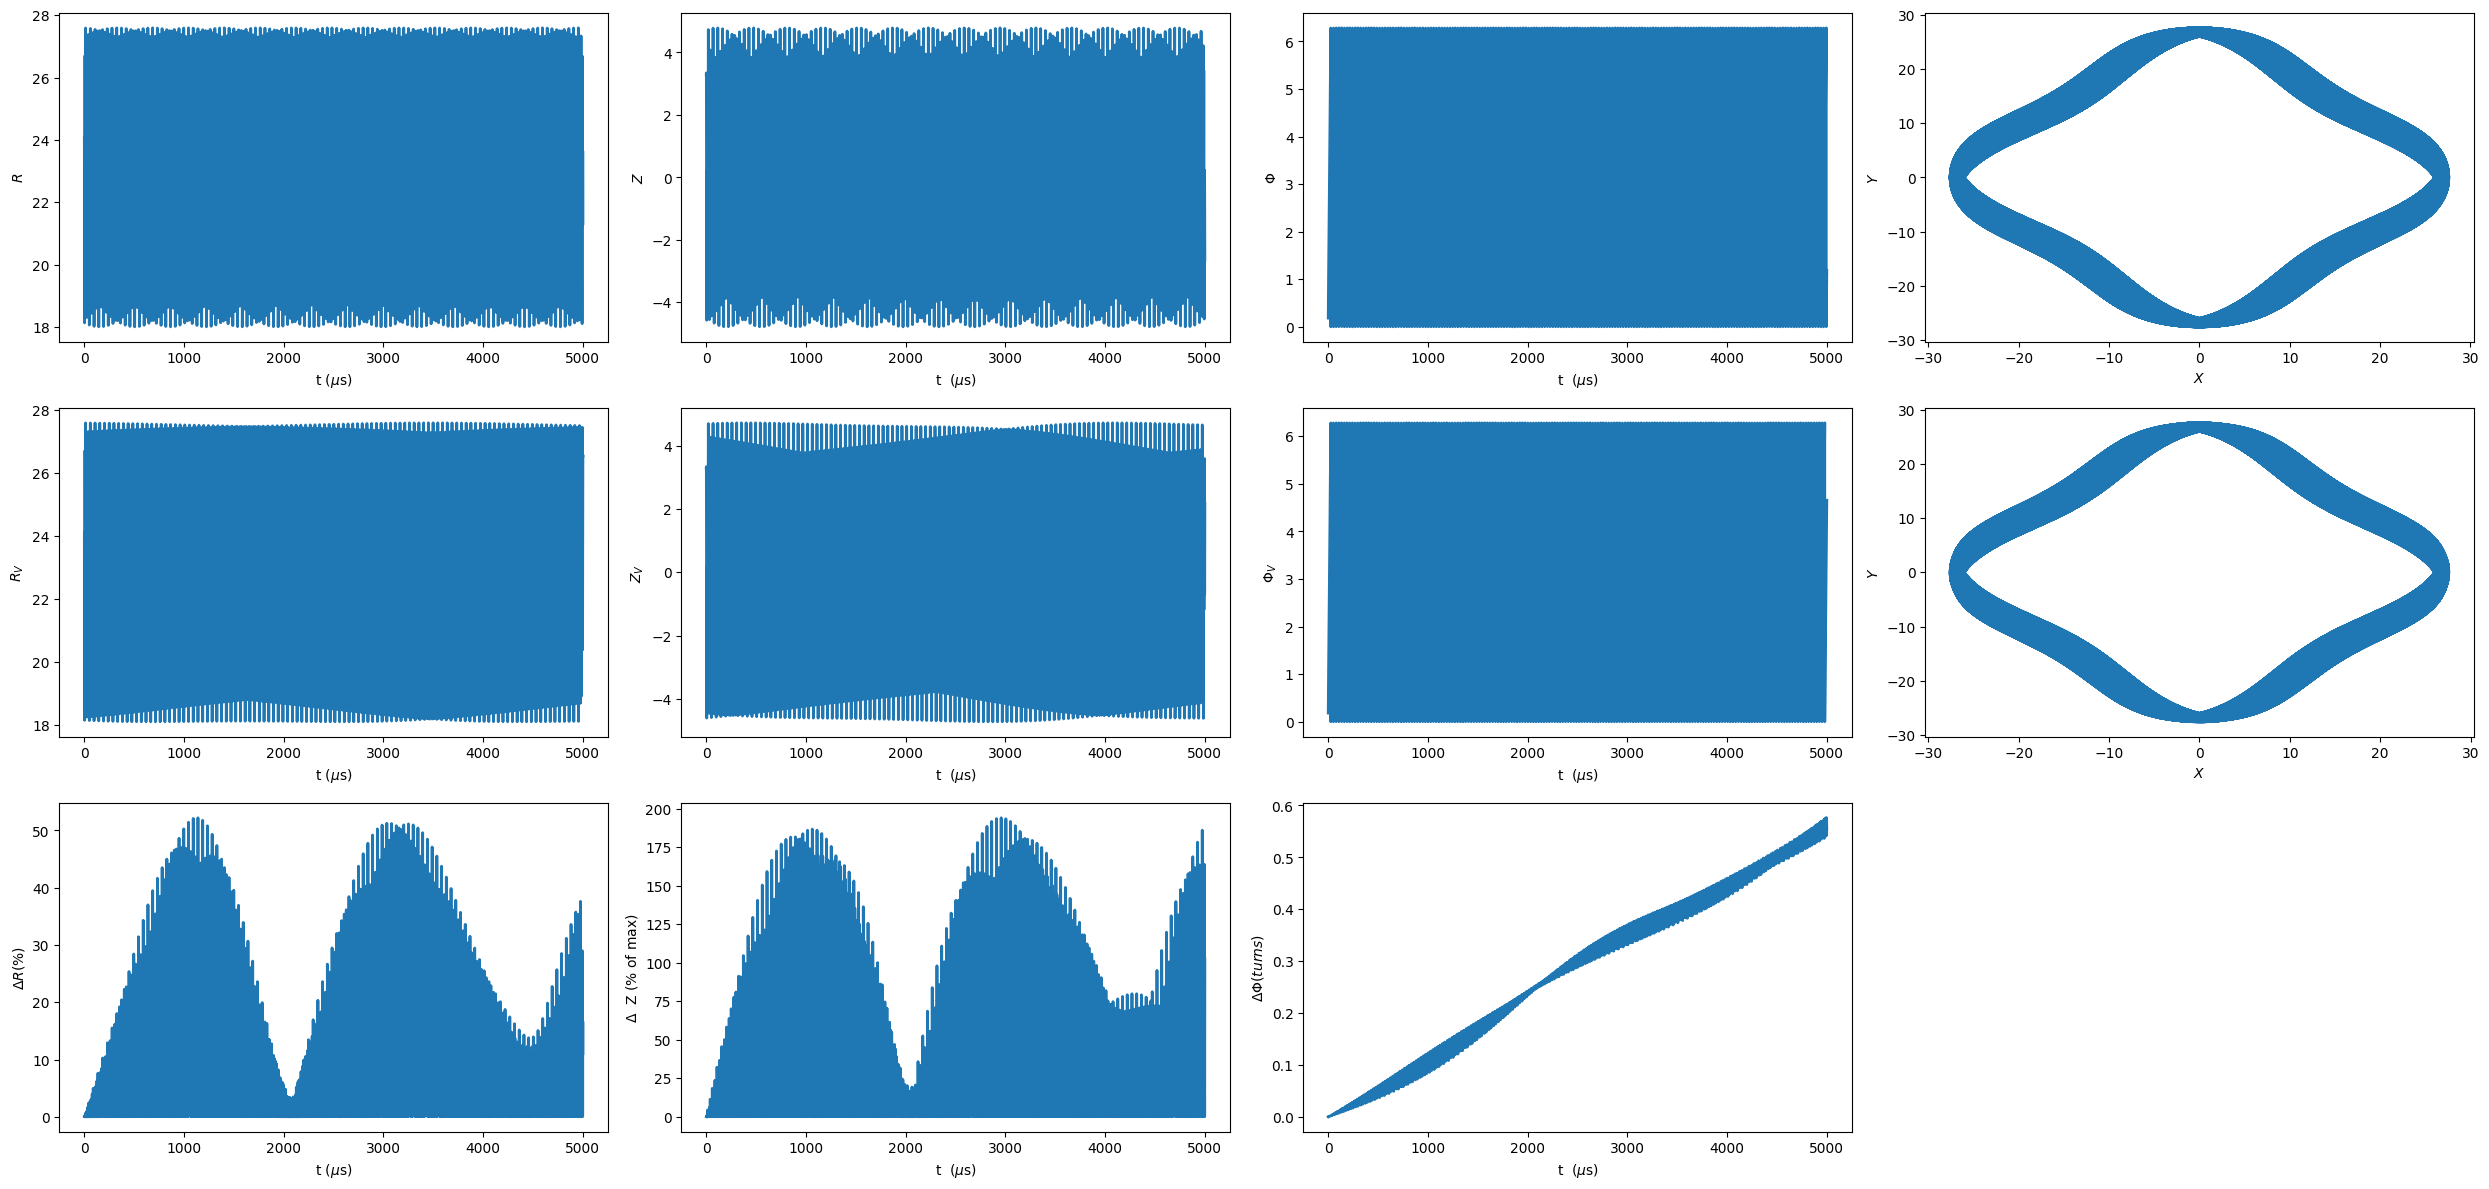

VMEC-SIMPLE


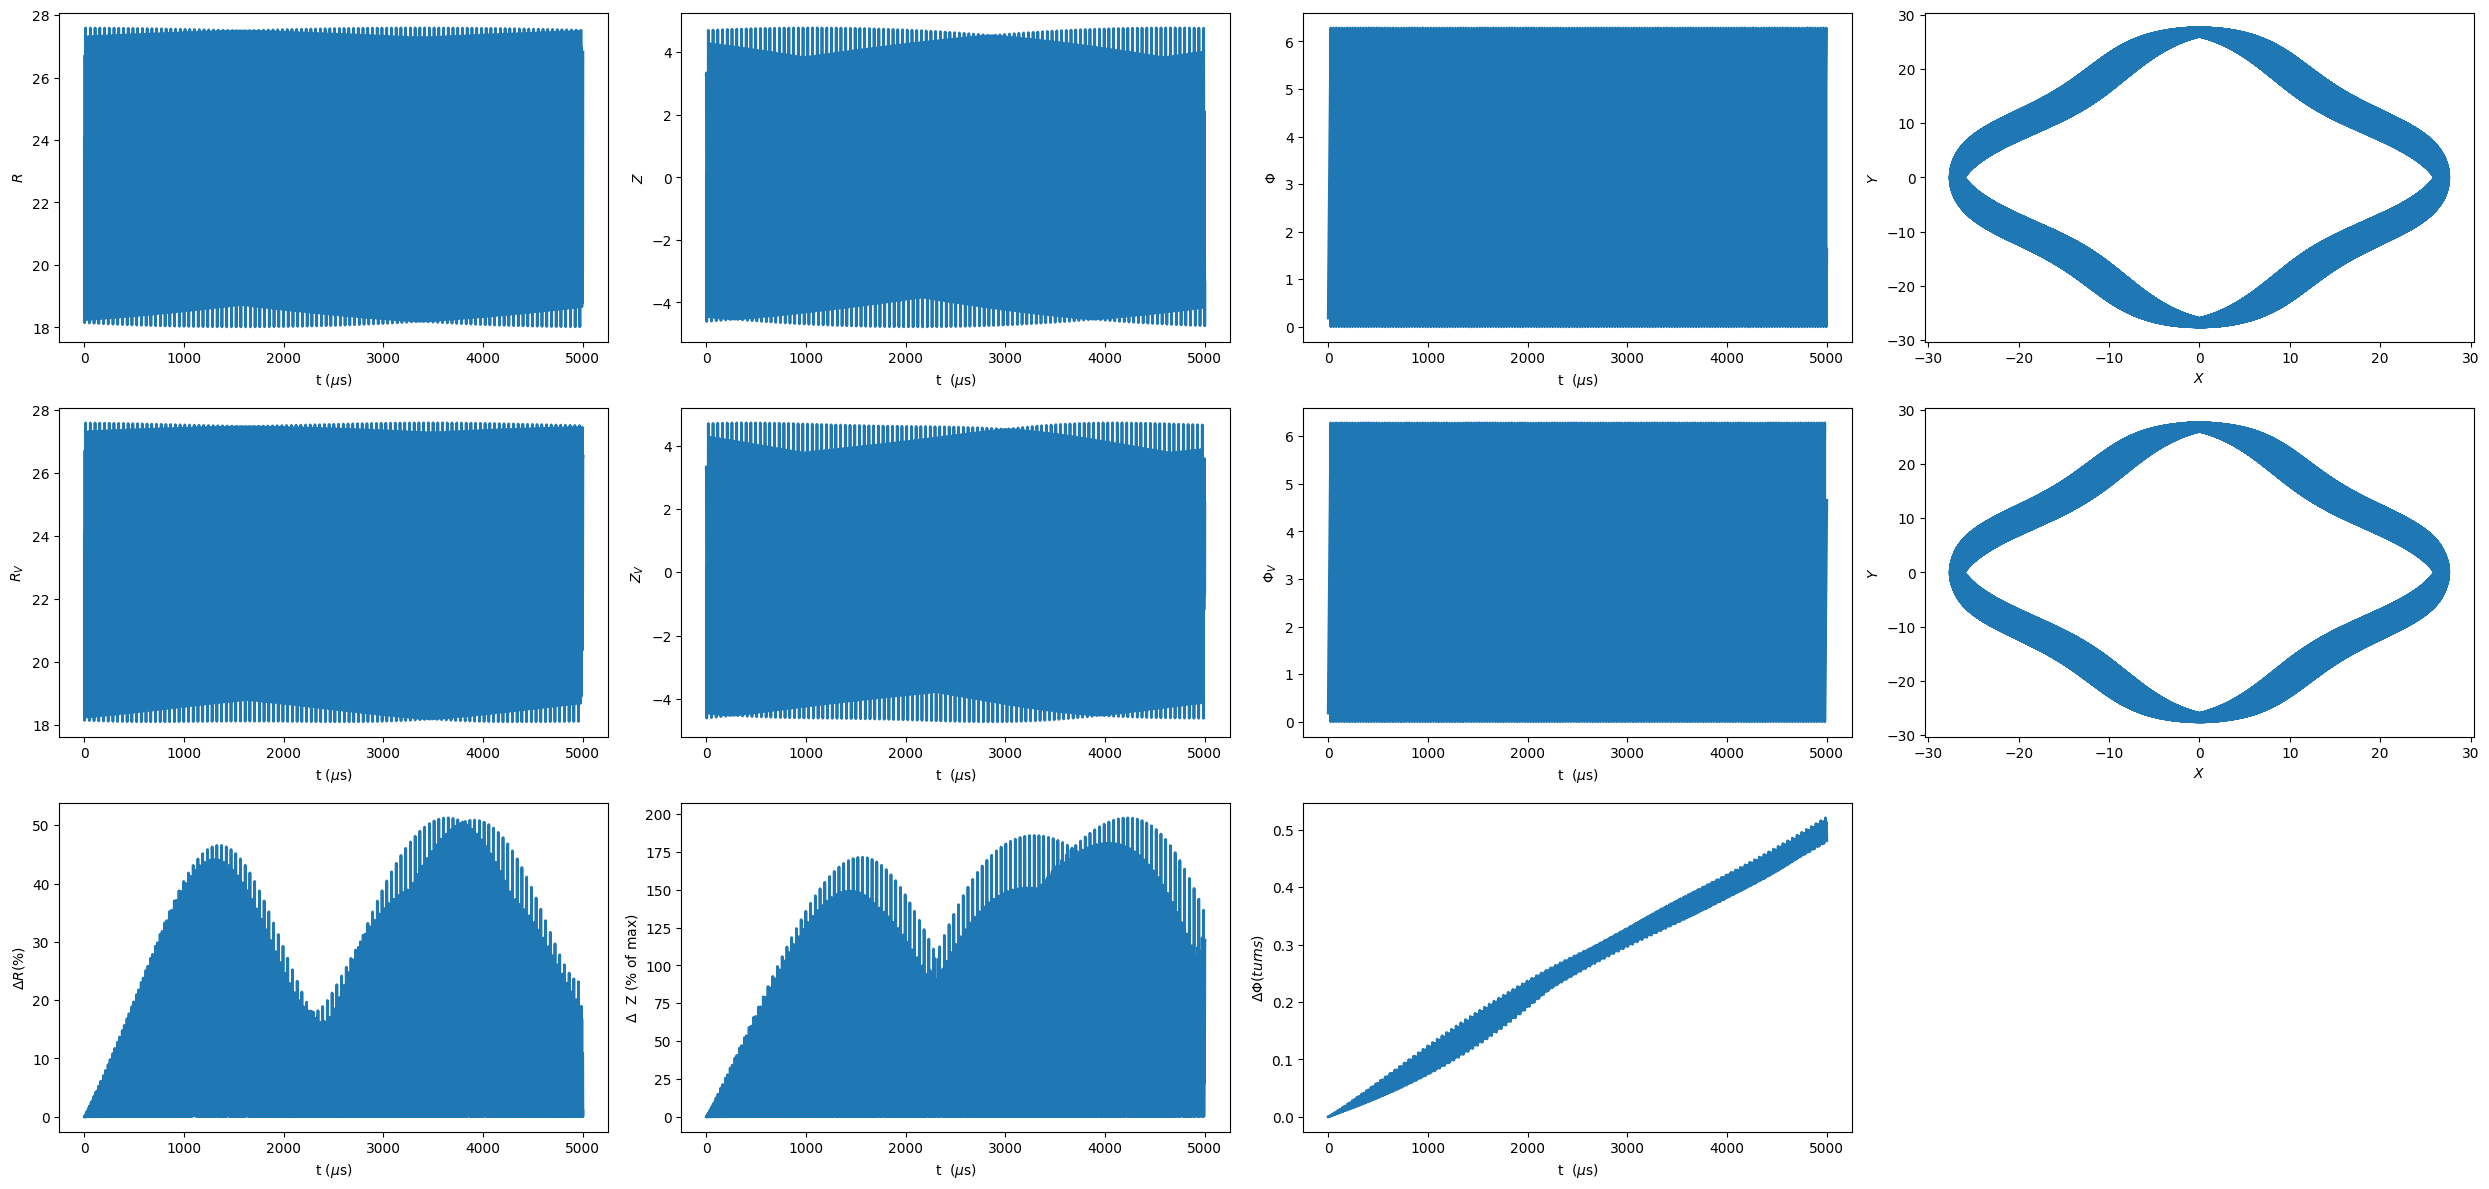

NEAT


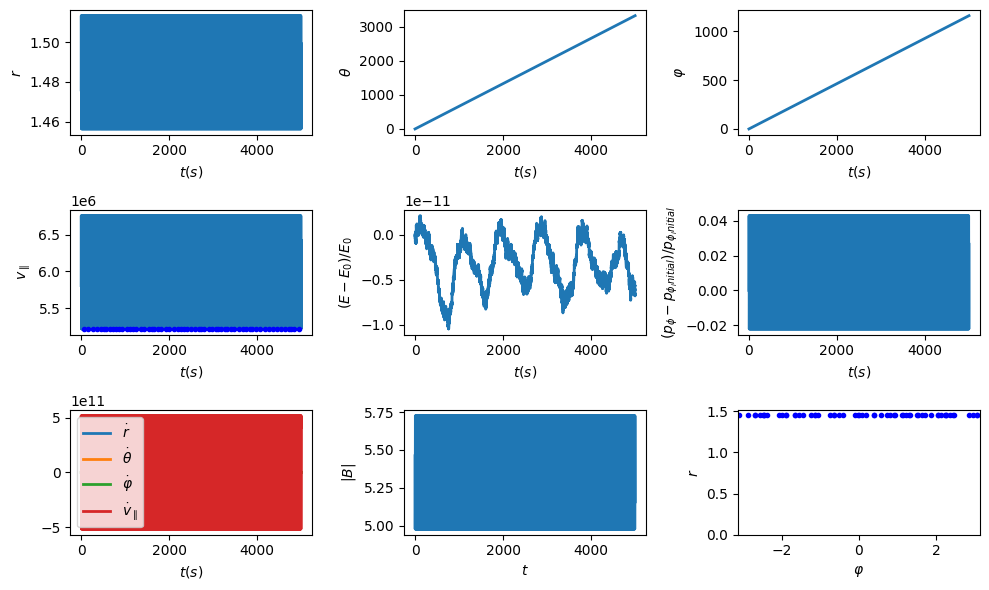

VMEC


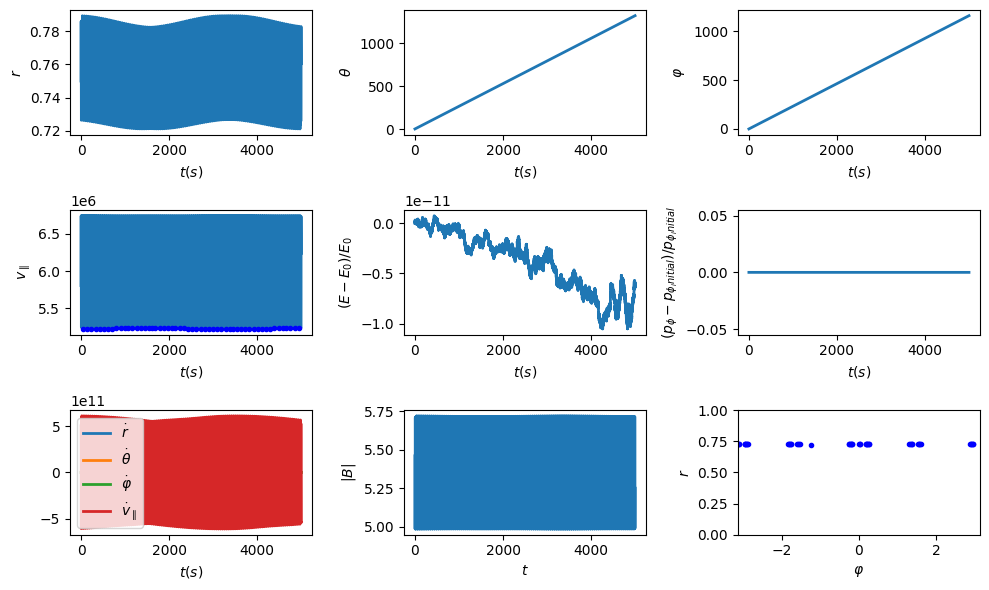

SIMPLE


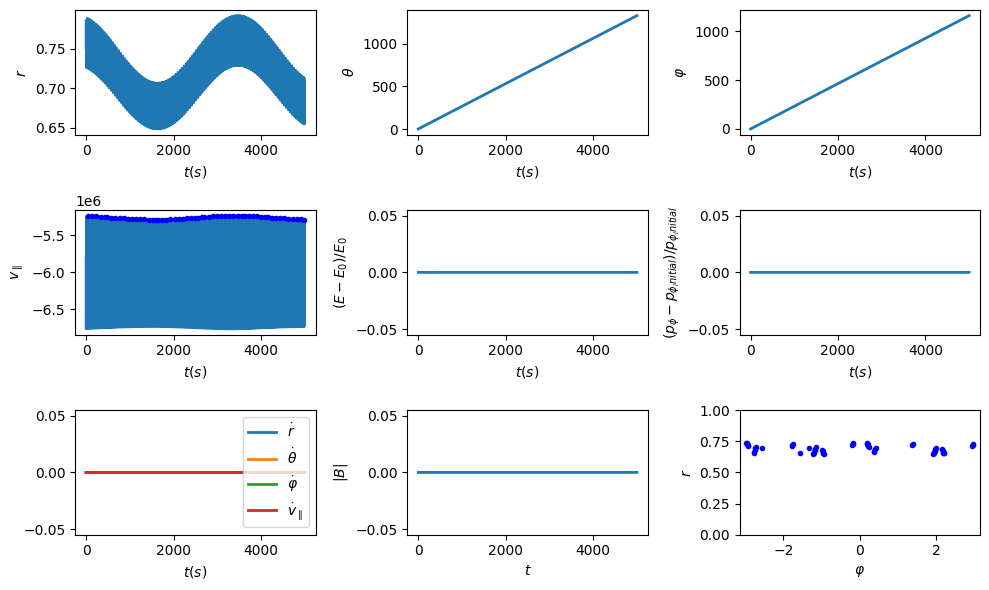

In [9]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams['lines.linewidth'] = 2
if not os.path.exists(stellarator + '_A=' + str(Rmajor_ARIES/r_avg)):
    os.mkdir('A=' + str(Rmajor_ARIES/r_avg))
norms_r_pos=[]
norms_r_pos_filt=[]
plt.figure(figsize=(10, 6))
for i in np.arange(0,len(g_orbits),1):  
    s_i=np.round(0.1 + step_i*i,2)
    if not os.path.exists(stellarator + '_A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(s_i)):
        os.mkdir(stellarator + '_A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(s_i))
    norm_r_pos = (g_orbits[i].r_pos/(r_avg))**2
    # peaks, _= signal.find_peaks(norm_r_pos,distance=(4/100)*g_orbits[i].time.size)
    # valleys,_= signal.find_peaks(-norm_r_pos,distance=(4/100)*g_orbits[i].time.size)

    # if peaks.size>valleys.size: peaks=peaks[:valleys.size]
    # else: valleys=valleys[:peaks.size]

    # peaks2, _= signal.find_peaks(g_orbits_desc[i].r_pos,distance=(8/100)*g_orbits[i].time.size)
    # valleys2,_= signal.find_peaks(-g_orbits_desc[i].r_pos,distance=(8/100)*g_orbits[i].time.size)

    # if peaks2.size>valleys2.size: peaks2=peaks2[:valleys2.size]
    # else: valleys2=valleys2[:peaks2.size]

    # peaks3, _= signal.find_peaks(g_orbits_vmec[i].r_pos,distance=(8/100)*g_orbits[i].time.size)
    # valleys3,_= signal.find_peaks(-g_orbits_vmec[i].r_pos,distance=(8/100)*g_orbits[i].time.size)

    # if peaks3.size>valleys3.size: peaks3=peaks3[:valleys3.size]
    # else: valleys3=valleys3[:peaks3.size]    

    # fs = 1 / ( g_orbits[i].time[1] - g_orbits[i].time[0] )  # Sampling frequency
    # cutoff = 1e4                     # Frequency cutoff value in Hz

    # norm_r_pos_filt = butter_lowpass_filter(norm_r_pos, cutoff, fs)
    # r_pos_filt2 = butter_lowpass_filter2(g_orbits_desc[i].r_pos, cutoff, fs)
    # r_pos_filt3 = butter_lowpass_filter2(g_orbits_vmec[i].r_pos, cutoff, fs)

    # diff_s_filt2=norm_r_pos_filt - r_pos_filt2
    # diff_s_filt3=norm_r_pos_filt - r_pos_filt3
    # plt.plot(g_orbits_vmec[i].time*1e6, np.abs(diff_s_filt2), label='DESC s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits_vmec[i].time*1e6, np.abs(diff_s_filt3), label='VMEC s_i='+str(np.round(0.1 + step_i*i,2)))

    # avg_time=(g_orbits[i].time[peaks]+g_orbits[i].time[valleys])*1e6/2
    # avg_time2=(g_orbits_desc[i].time[peaks2]+g_orbits_desc[i].time[valleys2])*1e6/2
    # avg_time3=(g_orbits_vmec[i].time[peaks3]+g_orbits_vmec[i].time[valleys3])*1e6/2

    # plt.plot(avg_time-avg_time[0]/2, norm_r_pos[peaks]-norm_r_pos[valleys],label='NA s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(avg_time2-avg_time2[0]/2, g_orbits_desc[i].r_pos[peaks2]-g_orbits_desc[i].r_pos[valleys2],label='DESC s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(avg_time3-avg_time3[0]/2, g_orbits_vmec[i].r_pos[peaks3]-g_orbits_vmec[i].r_pos[valleys3],label='VMEC s_i='+str(np.round(0.1 + step_i*i,2)))
    plt.figure(figsize=(10, 6))
    plt.rcParams["figure.facecolor"] = "w"
    plt.plot(g_orbits_vmec[i].time*1e6, g_orbits_vmec[i].r_pos, label='VMEC - gyronimo' , ls='dashdot', lw=1)
    # plt.plot(g_orbits_vmec[i].time[valleys2]*1e6, g_orbits_vmec[i].r_pos[valleys2], label='vmec s_i='+str(np.round(0.1 + step_i*i,2)), ls='None',marker='.')
    # plt.plot(g_orbits_desc[i].time*1e6, g_orbits_desc[i].r_pos, label='desc s_i='+str(np.round(0.1 + step_i*i,2)))
    plt.plot(g_orbits_simple[i].time*1e6, g_orbits_simple[i].r_pos, label='VMEC - SIMPLE', ls='dotted', lw=1)
    plt.plot(g_orbits[i].time*1e6, norm_r_pos, label='pyQSC - gyronimo', ls='dashdot', lw=1)
    # plt.show()
    # plt.plot(g_orbits_simple[i].time*1e6, np.pi + g_orbits_simple[i].theta_pos,label='simple s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits[i].time*1e6, g_orbits[i].theta_pos,label=' s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.show()
    # plt.plot(g_orbits_simple[i].time*1e6, g_orbits_simple[i].varphi_pos,label='simple s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits[i].time*1e6, g_orbits[i].varphi_pos,label=' s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.show()
    # plt.plot(g_orbits[i].time*1e6, g_orbits[i].rpos_cylindrical[0],label=' s_i='+str(np.round(0.1 + step_i*i,2)), ls='None',marker='.')
    # plt.plot(g_orbits_simple[i].time*1e6, g_orbits_simple[i].rpos_cylindrical[0],label='simple s_i='+str(np.round(0.1 + step_i*i,2)), ls='None',marker='.')
    # plt.plot(g_orbits_simple[i].time*1e6, 100*(g_orbits_simple[i].rpos_cylindrical[0]-g_orbits[i].rpos_cylindrical[0])/g_orbits[i].rpos_cylindrical[0],label='simple s_i='+str(np.round(0.1 + step_i*i,2)), ls='None',marker='.')

    plt.legend(fontsize=8, loc=(0.81,0.02))
    plt.xlabel(r't ($\mu$s)')
    # plt.xlim(60,61)
    # plt.ylim(0.09,0.12)
    plt.savefig(stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/r_pos',transparent=False)
    plt.show()
    print('NEAT')
    g_orbits[i].plot_orbit_contourB(savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/B_neat')
    print('VMEC')
    g_orbits_vmec[i].plot_orbit_contourB(savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/B_vmec')
    # print('DESC')
    # g_orbits_desc[i].plot_orbit_contourB()
    print('SIMPLE')
    g_orbits_simple[i].plot_orbit_contourB(savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/B_simple')
    print('NEAT-VMEC')
    g_orbits[i].plot_diff_boozer(g_orbits_vmec[i],r_minor=r_avg,savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_booz_neat_vmec')
    # print('NEAT-DESC')
    # g_orbits[i].plot_diff_boozer(g_orbits_desc[i],r_minor=r_avg)
    print('NEAT-SIMPLE')
    g_orbits[i].plot_diff_boozer(g_orbits_simple[i],r_minor=r_avg,savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_booz_neat_simple')
    print('VMEC-SIMPLE')
    g_orbits_vmec[i].plot_diff_boozer(g_orbits_simple[i],r_minor=1,savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_booz_vmec_simple')
    print('NEAT-VMEC')
    g_orbits[i].plot_diff_cyl(g_orbits_vmec[i],savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_cyl_neat_vmec')
    # print('NEAT-DESC')
    # g_orbits[i].plot_diff_cyl(g_orbits_desc[i])
    print('NEAT-SIMPLE')
    g_orbits[i].plot_diff_cyl(g_orbits_simple[i],savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_cyl_neat_simple')
    print('VMEC-SIMPLE')
    g_orbits_vmec[i].plot_diff_cyl(g_orbits_simple[i],savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_cyl_vmec_simple')
    print('NEAT')
    g_orbits[i].plot(savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/param_neat')
    print('VMEC')
    g_orbits_vmec[i].plot(savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/param_vmec')
    # print('DESC')
    # g_orbits_desc[i].plot()
    print('SIMPLE')
    g_orbits_simple[i].plot(savefig=stellarator + '_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/param_simple')
    # plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)

    # g_orbits[i].plot_orbit_3d(show=True, r_surface=r_avg, savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[1]) + '_s_i=' + str(s_initial) + \
    #     '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_neat_orbit.png')
    # g_orbits_vmec[i].plot_orbit_3d(show=True,savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[1]) + '_s_i=' + str(s_initial) + \
    #     '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_vmec_orbit.png')
    # g_orbits_desc[i].plot_orbit_3d(show=True,savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[1]) + '_s_i=' + str(s_initial) + \
    #     '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_vmec_orbit.png')
    # try:
    #     max=np.minimum(avg_time[-1],avg_time2[-1],avg_time3[-1])
    #     plt.xlim(0,max)
    # except:
    #     print('No radial oscillation')
    # g_orbits[i].plot_orbit_contourB(show=True, savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[0]) + '_s_i=' + str(s_initial) + \
    #      '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_neat_orbit.png')
    


# plt.xlabel(r't ($\mu$s)')
# plt.ylabel(r"Radial oscillation amplitude")
# plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
# plt.ylabel(r'Average radial difference')
# plt.legend(fontsize='small', loc=(0.6,0.1),ncol=2)
# plt.ylabel(r"s")
# plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
plt.show()


In [7]:
# plt.figure(figsize=(10, 6))
# for i in np.arange(0,1,1): 
#     avg_time=(g_orbits[i].time[peaks]+g_orbits[i].time[valleys])*1e6/2
#     avg_time2=(g_orbits_vmec[i].time[peaks2]+g_orbits_vmec[i].time[valleys2])*1e6/2
#     plt.plot(avg_time, norm_r_pos[peaks]-norm_r_pos[valleys],label='All NA')
#     plt.plot(avg_time2, g_orbits_vmec[i].r_pos[peaks2]-g_orbits_vmec[i].r_pos[valleys2],label='Non-NA s_i='+str(np.round(0.1 + 0.3*i,2)))
#     try:
#         max=np.minimum(avg_time[-1],avg_time2[-1])
#         plt.xlim(0,max)
#     except:
#         print('No radial oscillation')



# plt.xlabel(r't ($\mu$s)')
# plt.ylabel(r"Radial oscillation amplitude")
# plt.legend(fontsize='small', loc=(0.05,0.1))
# plt.show()

In [8]:

# print(g_field.etabar)
# print(g_field.r1_diagnostics)